# Part I - Registered Voter Participation in Union County, NC

## Merge, Scrub, and Initial Exploration of Voter Registration and History Data

<font size=4rem>
    
- **[Introduction](#Introduction)<br>**

- **[Obtain](#Obtain)**<br>

- **[Scrub and Explore](#scrub_explore)**<br>

    - **[Voter Registration and History](#vote_reg_his)**<br>

    - **[Major Elections](#maj_elec)**<br>

</font>

# Introduction

The 2020 general election saw many key <a href="https://www.cnn.com/election/2020/results/president"> battleground states</a> battleground states with extremely close margins for not only the presidential race, but for races at virtually every level of the ballot. This resulted in recounts in several states and Senate runoff elections in Georgia. We also witnessed the <a href="https://www.washingtonpost.com/graphics/2020/elections/voter-turnout/">highest voter turnout in over a century</a>, with 2/3 of every American elligible to vote casting a ballot.

Many of the battleground states flipped from red to blue during the 2020 election in the midst of this massive voter turnout. However, my home state of North Carolina was not one of them. The 2020 election saw above average <a href="https://www.statista.com/statistics/1184621/presidential-election-voter-turnout-rate-state/"> voter turnout in NC</a> as compared to the country as a whole, with 71.5% of elligible North Carolinians showing up at the polls. In the last 3 presidential elections, North Carolina has made the list of <a href="https://www.cnn.com/2020/11/09/politics/2020-election-trump-biden-closest-states/index.html"> top 10 states</a> with the closest margin. This was also reflected at the state level in 2020, with one <a href="https://ballotpedia.org/North_Carolina_Supreme_Court_elections,_2020"> NC Supreme Court race</a> being decided by a margin of just 412 votes after a recount. When political races are as close as we saw in the 2020 general election, absolutely every vote counts. Thus, it is important to understand who is voting, and who is failing to turnout to the polls.

This project focuses on examining trends in voter turnout in the 2012, 2016, and 2020 elections in Union County, NC. I intend to scale up to examining statewide trends once finalized voter history records have been released for the 2020 general election for every county. I combined information from NC voter registration records with records of each registered individual's voting history, and built models to predict whether or not an individual participated (Vote vs. No Vote) and what voting method they used (Early, Election Day, or No Vote), with separate models for each year. 

Across all years, it was relatively difficult to predict a voter's participation in Union County based solely on the demographic information included in voter registration records. Binary (Vote vs. No Vote) model performance tended to max out at around 67% overall accuracy, with better performance correctly classifying people who did cast a ballot. Multiclass (Early, Election Day, No Vote) model performance tended to max out at around 50% overall accuracy. Interpretation of each model and a comparison of general elections by year for Union County can be found in <a href="https://github.com/zero731/NC_Elections_Capstone/blob/main/Final_Part_III_Model_Interpret_UC_Elecs.ipynb"> Part III</a> Part III of this project. Additionally, as part of this project, I created an interactive dashboard to help visualize trends in voter participation and demographics in Union County, NC. I will post the link here when it has been launched.

# Obtain

The data used for this project were obtained from the North Carolina State Board of Elections (NCSBE). Both <a href="https://www.ncsbe.gov/results-data/voter-registration-data"> voter registration records</a> and <a href="https://www.ncsbe.gov/results-data/voter-history-data"> voter history records</a> are made available and updated weekly. Voter history records do not contain demographic information, but the two files can be merged according to a unique ID (`ncid`) assigned to each registered voter in the state of North Carolina.

In this notebook, I merged the two files (data used for the current version of this project obtained from the NCSBE site on January 4, 2021) to obtain a single dataframe containing both demographic and vote history information for each registered voter in Union County. To see an explanation of my next major steps in cleaning and preparing the data for visualizing and modeling, see the beginning of the [Scrub and Explore](#scrub_explore) section of this notebook. Some of the steps taken were necessary, but somewhat limit the scope of how the models can be applied and how trends should be interpreted.

In [182]:
## Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt

## Import functions made specifically for this project
from capstone_functions import *

In [183]:
## Set options for displaying Pandas DataFrames
pd.options.display.max_columns = 100
pd.options.display.max_rows = 120

In [184]:
## Load in voter registration data for Union County
uc_vreg = pd.read_table('Data/ncvoter90_Jan4.zip', encoding='ISO-8859-1')
uc_vreg.head()

county_id county_desc  voter_reg_num status_cd voter_status_desc reason_cd  \
0         90       UNION         346446         A            ACTIVE        AV   
1         90       UNION         348004         A            ACTIVE        AV   
2         90       UNION         281016         A            ACTIVE        AV   
3         90       UNION         288489         A            ACTIVE        AV   
4         90       UNION         279308         A            ACTIVE        AV   

  voter_status_reason_desc absent_ind name_prefx_cd last_name first_name  \
0                 VERIFIED                             AALAEI       ARIO   
1                 VERIFIED                             AALAEI    KAVITHA   
2                 VERIFIED                            AALBORG     ALEXIS   
3                 VERIFIED                            AALBORG      BRYAN   
4                 VERIFIED                            AALBORG     SHARON   

    middle_name name_suffix_lbl         res_street_address res_city_desc  \
0           NaN             NaN   4009  MILLBRIDGE PKWY           WAXHAW   
1           NaN             NaN   4009  MILLBRIDGE PKWY           WAXHAW   
2         LEANN             NaN  1001  STEVENS PRIDE CT     INDIAN TRAIL   
3           LEE             NaN  1001  STEVENS PRIDE CT     INDIAN TRAIL   
4  SCHLEENBAKER             NaN  1001  STEVENS PRIDE CT     INDIAN TRAIL   

  state_cd  zip_code             mail_addr1 mail_addr2 mail_addr3 mail_addr4  \
0       NC   28173.0   4009 MILLBRIDGE PKWY        NaN        NaN        NaN   
1       NC   28173.0   4009 MILLBRIDGE PKWY        NaN        NaN        NaN   
2       NC   28079.0  1001 STEVENS PRIDE CT        NaN        NaN        NaN   
3       NC   28079.0  1001 STEVENS PRIDE CT        NaN        NaN        NaN   
4       NC   28079.0  1001 STEVENS PRIDE CT        NaN        NaN        NaN   

      mail_city mail_state mail_zipcode  full_phone_number race_code  \
0        WAXHAW         NC        28173                NaN         W   
1        WAXHAW         NC        28173                NaN         A   
2  INDIAN TRAIL         NC        28079                NaN         W   
3  INDIAN TRAIL         NC        28079                NaN         W   
4  INDIAN TRAIL         NC        28079                NaN         W   

  ethnic_code party_cd gender_code  birth_age birth_state drivers_lic  \
0          NL      UNA           M         47          OC           Y   
1          NL      DEM           F         47          OC           Y   
2          NL      UNA           F         27          IA           Y   
3          UN      UNA           M         63          OK           Y   
4          NL      REP           F         63          PA           Y   

   registr_dt precinct_abbrv precinct_desc  municipality_abbrv  \
0  04/25/2019           020A          020A                 5.0   
1  06/24/2019           020A          020A                 5.0   
2  11/04/2013           029A          029A                 6.0   
3  09/17/2014           029A          029A                 6.0   
4  07/24/2013           029A          029A                 6.0   

  municipality_desc  ward_abbrv  ward_desc  cong_dist_abbrv super_court_abbrv  \
0            WAXHAW         NaN        NaN              9.0               20B   
1            WAXHAW         NaN        NaN              9.0               20B   
2      INDIAN TRAIL         NaN        NaN              9.0               20B   
3      INDIAN TRAIL         NaN        NaN              9.0               20B   
4      INDIAN TRAIL         NaN        NaN              9.0               20B   

  judic_dist_abbrv  nc_senate_abbrv  nc_house_abbrv  county_commiss_abbrv  \
0              20C             35.0            68.0                   NaN   
1              20C             35.0            68.0                   NaN   
2              20C             35.0            68.0                   NaN   
3              20C             35.0            68.0      

In [185]:
## Load in voter history data for Union County
uc_vhis = pd.read_table('Data/ncvhis90_Jan4.zip')
uc_vhis.head()

county_id county_desc  voter_reg_num election_lbl       election_desc  \
0         90       UNION         285297   11/08/2016  11/08/2016 GENERAL   
1         90       UNION         285297   09/10/2019  09/10/2019 GENERAL   
2         90       UNION         285297   03/03/2020  03/03/2020 PRIMARY   
3         90       UNION         285297   11/06/2018  11/06/2018 GENERAL   
4         90       UNION         285297   11/03/2020  11/03/2020 GENERAL   

      voting_method voted_party_cd voted_party_desc pct_label pct_description  \
0  ABSENTEE ONESTOP            REP       REPUBLICAN       016             016   
1  ABSENTEE ONESTOP            REP       REPUBLICAN       016             016   
2         IN-PERSON            REP       REPUBLICAN       016             016   
3  ABSENTEE ONESTOP            REP       REPUBLICAN       016             016   
4  ABSENTEE ONESTOP            REP       REPUBLICAN       016             016   

       ncid  voted_county_id voted_county_desc vtd_label vtd_description  
0  AA100547               90             UNION       016             016  
1  AA100547               90             UNION       016             016  
2  AA100547               90             UNION       016             016  
3  AA100547               90             UNION       016             016  
4  AA100547               90             UNION       016             016

<a id='scrub_explore'></a>
# Scrub and Explore

The major steps I took in cleaning and preparing the data for modelling and visualizing were as follows:
1. **Drop duplicate records from both voter history records.** This included identical duplicates and records/ rows that were not completely identical, but shared the same combination of `ncid` (unique voter ID) and `election_desc` (the specific election for which the voter cast a ballot). Each `ncid` should only show up in a given election once, since each voter gets a single vote. To see the code and explanation for how this problem was handled, jump to [this section](#drop_dup).
2. **Drop voter registration records for individuals with "Removed" or "Denied" status.** These individuals are currently (as of January 4) inelligible to vote within Union County. Because the records do not indicate when their status was changed, I could not account for the fact that they may have been elligible to vote in either the 2012 or 2016 election. Thus the dataframes for those elections may be missing individuals who were elligible to vote then, but not in 2020.
3. **Merge cleaned voter history data onto cleaned voter registration data on `ncid`.**
4. **Create a separate dataframe for each election (general 2012, 2016, and 2020).** Individuals were excluded from an election dataframe for a given year if they were not registered in time to vote in that election, or if they were too young to vote that year. This left one record per elligible, registered individual in each dataset, even if they did not cast a vote in that particular year.

<a id='vote_reg_his'></a>
## Vote Registration and History

In [186]:
## Check metadata for voter registration dataframe
uc_vreg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185008 entries, 0 to 185007
Data columns (total 71 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   county_id                 185008 non-null  int64  
 1   county_desc               185008 non-null  object 
 2   voter_reg_num             185008 non-null  int64  
 3   status_cd                 185008 non-null  object 
 4   voter_status_desc         185008 non-null  object 
 5   reason_cd                 185008 non-null  object 
 6   voter_status_reason_desc  185008 non-null  object 
 7   absent_ind                185008 non-null  object 
 8   name_prefx_cd             185008 non-null  object 
 9   last_name                 185004 non-null  object 
 10  first_name                185005 non-null  object 
 11  middle_name               169910 non-null  object 
 12  name_suffix_lbl           21203 non-null   object 
 13  res_street_address        185008 non-null  o

In [187]:
## Check metadata for voter history dataframe
uc_vhis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807296 entries, 0 to 807295
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   county_id          807296 non-null  int64 
 1   county_desc        807296 non-null  object
 2   voter_reg_num      807296 non-null  int64 
 3   election_lbl       807296 non-null  object
 4   election_desc      807296 non-null  object
 5   voting_method      807296 non-null  object
 6   voted_party_cd     807232 non-null  object
 7   voted_party_desc   807232 non-null  object
 8   pct_label          807296 non-null  object
 9   pct_description    807296 non-null  object
 10  ncid               807296 non-null  object
 11  voted_county_id    807296 non-null  int64 
 12  voted_county_desc  807296 non-null  object
 13  vtd_label          807118 non-null  object
 14  vtd_description    807118 non-null  object
dtypes: int64(3), object(12)
memory usage: 92.4+ MB


### Explore Duplicate Records

In [188]:
## Check for duplicate entries in voter registration data
uc_vreg.duplicated().sum()

0

In [189]:
## Check for duplicate entries in voter history data
uc_vhis.duplicated().sum()

134

In [190]:
## Inspect duplicate entries in voter history data
exact_dup_vhis = uc_vhis.loc[uc_vhis.duplicated()]
exact_dup_vhis

county_id county_desc  voter_reg_num election_lbl       election_desc  \
9068           90       UNION         325228   09/10/2019  09/10/2019 GENERAL   
9069           90       UNION         325228   03/03/2020  03/03/2020 PRIMARY   
26484          90       UNION         205258   11/06/2012  11/06/2012 GENERAL   
36111          90       UNION         338757   11/06/2018  11/06/2018 GENERAL   
75412          90       UNION         204911   11/06/2012  11/06/2012 GENERAL   
...           ...         ...            ...          ...                 ...   
746935         90       UNION          10836   11/08/2016  11/08/2016 GENERAL   
768089         90       UNION         338953   11/06/2018  11/06/2018 GENERAL   
768963         90       UNION         167702   05/08/2012  05/08/2012 PRIMARY   
773429         90       UNION         271801   11/06/2012  11/06/2012 GENERAL   
782492         90       UNION         172038   11/06/2012  11/06/2012 GENERAL   

           voting_method voted_party_cd voted_party_desc pct_label  \
9068           IN-PERSON            DEM       DEMOCRATIC      020A   
9069    ABSENTEE ONESTOP            DEM       DEMOCRATIC      020A   
26484   ABSENTEE ONESTOP            UNA     UNAFFILIATED      029C   
36111        PROVISIONAL            REP       REPUBLICAN      037A   
75412   ABSENTEE ONESTOP            DEM       DEMOCRATIC       036   
...                  ...            ...              ...       ...   
746935  ABSENTEE ONESTOP            REP       REPUBLICAN       024   
768089       PROVISIONAL            UNA     UNAFFILIATED       012   
768963         IN-PERSON            REP       REPUBLICAN       036   
773429  ABSENTEE ONESTOP            REP       REPUBLICAN       042   
782492         IN-PERSON            UNA     UNAFFILIATED       013   

       pct_description       ncid  voted_county_id voted_county_desc  \
9068              020A   AN168178               90             UNION   
9069              020A   AN168178               90             UNION   
26484             029C    CE19807               90             UNION   
36111             037A  CW1070559               90             UNION   
75412              036   CW455149               90             UNION   
...                ...        ...              ...               ...   
746935             024     EF8430               90             UNION   
768089             012    EF90843               90             UNION   
768963             036    EF91060               90             UNION   
773429             042    EF92439               90             UNION   
782492             013    EF95396               90             UNION   

       vtd_label vtd_description  
9068        020A            020A  
9069        020A            020A  
26484       029C            029C  
36111       037A            037A  
75412        036             036  
...          ...             ...  
746935       024             024  
768089       012             012  
768963       036             036  
773429       042             042  
782492       013             013  

[134 rows x 15 columns]

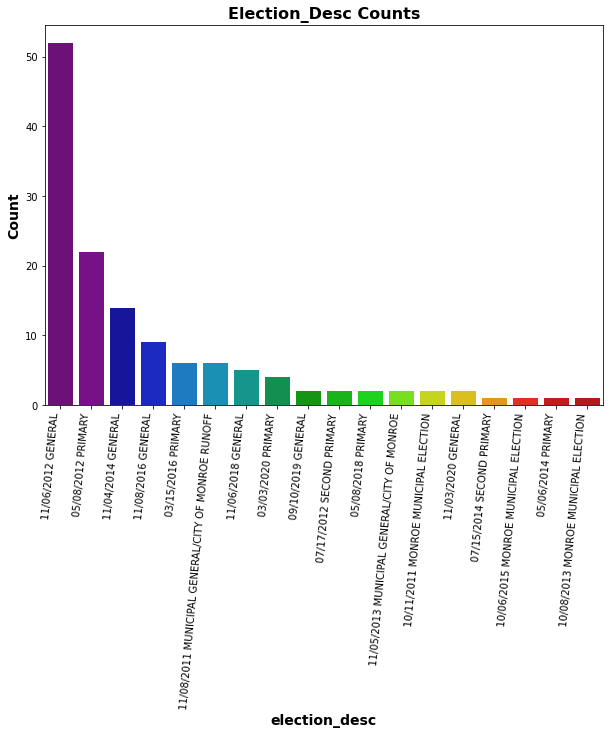

In [191]:
plot_count('election_desc', exact_dup_vhis, rotation=85, ha='right');

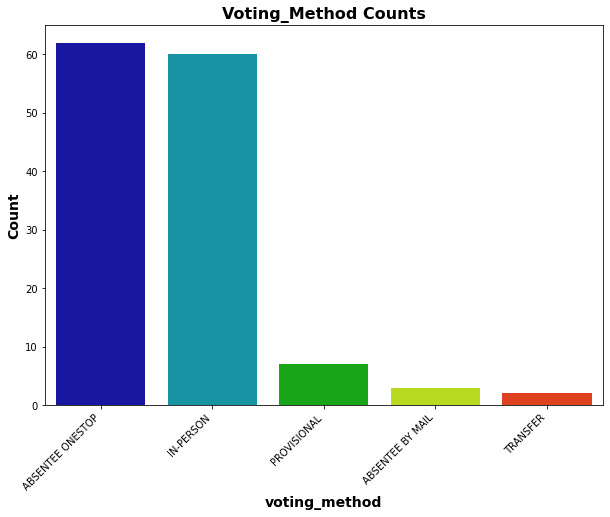

In [192]:
plot_count('voting_method', exact_dup_vhis, rotation=45, ha='right');

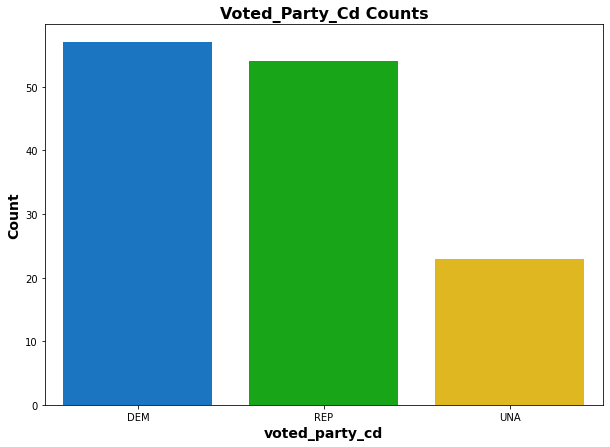

In [193]:
plot_count('voted_party_cd', exact_dup_vhis);

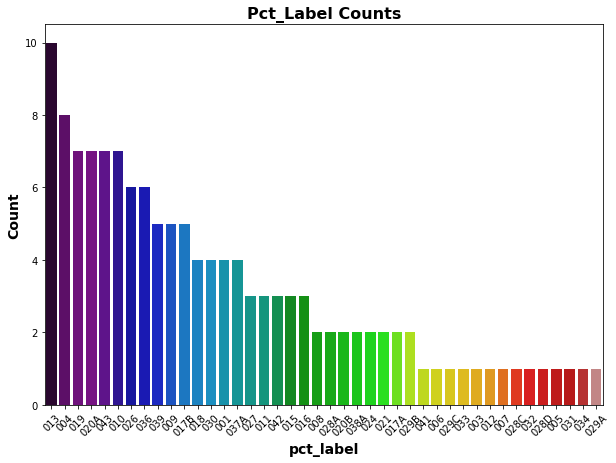

In [194]:
plot_count('pct_label', exact_dup_vhis, rotation=45);

In [195]:
## Remove exact duplicate entries from records of voter history
uc_vhis.drop_duplicates(inplace=True)

In [196]:
## There are 9 instances where an ncid shows up as casting a vote
  ## more than once in the same election where the records aren't exact copies
uc_vhis.duplicated(subset=['ncid','election_desc']).sum()

9

In [197]:
## A total of 7 individuals show up more than once for a single election
dup_ncid_elecs = uc_vhis.loc[uc_vhis.duplicated(subset=['ncid', 'election_desc'], keep=False)]
display(dup_ncid_elecs.head())
dup_ncid_elecs['ncid'].nunique()

county_id county_desc  voter_reg_num election_lbl       election_desc  \
31488          90       UNION         338735   11/06/2018  11/06/2018 GENERAL   
31492          90       UNION         338735   11/06/2018  11/06/2018 GENERAL   
149121         90       UNION         364740   11/08/2016  11/08/2016 GENERAL   
149122         90       UNION         364740   11/06/2012  11/06/2012 GENERAL   
149123         90       UNION         364740   03/15/2016  03/15/2016 PRIMARY   

           voting_method voted_party_cd voted_party_desc pct_label  \
31488        PROVISIONAL            REP       REPUBLICAN      020B   
31492          IN-PERSON            REP       REPUBLICAN       058   
149121  ABSENTEE ONESTOP            UNA     UNAFFILIATED       W16   
149122  ABSENTEE ONESTOP            UNA     UNAFFILIATED       W25   
149123  ABSENTEE ONESTOP            DEM       DEMOCRATIC       W16   

       pct_description       ncid  voted_county_id voted_county_desc  \
31488             020B  CW1012090               90             UNION   
31492          PCT 058  CW1012090               60       MECKLENBURG   
149121             W16   DB153036               65       NEW HANOVER   
149122             W25   DB153036               65       NEW HANOVER   
149123             W16   DB153036               65       NEW HANOVER   

       vtd_label vtd_description  
31488       020B            020B  
31492        058             058  
149121       W16             W16  
149122       W25             W25  
149123       W16             W16

7

In [198]:
## Examine the complete recent voting history of the 7 ncid's that show up 
  ## multiple times for a single election to investigate how the records differ
for ncid in dup_ncid_elecs['ncid'].unique():
    display(uc_vhis.loc[uc_vhis['ncid']==ncid].sort_values(['election_desc']))

county_id county_desc  voter_reg_num election_lbl  \
31487         90       UNION         338735   03/03/2020   
31490         90       UNION         338735   09/10/2019   
31495         90       UNION         338735   11/03/2015   
31489         90       UNION         338735   11/03/2020   
31494         90       UNION         338735   11/04/2014   
31491         90       UNION         338735   11/05/2019   
31488         90       UNION         338735   11/06/2018   
31492         90       UNION         338735   11/06/2018   
31493         90       UNION         338735   11/08/2016   

              election_desc     voting_method voted_party_cd voted_party_desc  \
31487    03/03/2020 PRIMARY  ABSENTEE ONESTOP            REP       REPUBLICAN   
31490    09/10/2019 GENERAL         IN-PERSON            REP       REPUBLICAN   
31495    11/03/2015 GENERAL         IN-PERSON            REP       REPUBLICAN   
31489    11/03/2020 GENERAL  ABSENTEE ONESTOP            REP       REPUBLICAN   
31494    11/04/2014 GENERAL         IN-PERSON            REP       REPUBLICAN   
31491  11/05/2019 MUNICIPAL         IN-PERSON            REP       REPUBLICAN   
31488    11/06/2018 GENERAL       PROVISIONAL            REP       REPUBLICAN   
31492    11/06/2018 GENERAL         IN-PERSON            REP       REPUBLICAN   
31493    11/08/2016 GENERAL         IN-PERSON            REP       REPUBLICAN   

      pct_label pct_description       ncid  voted_county_id voted_county_desc  \
31487      020B            020B  CW1012090               90             UNION   
31490      020B            020B  CW1012090               90             UNION   
31495       058         PCT 058  CW1012090               60       MECKLENBURG   
31489      020B            020B  CW1012090               90             UNION   
31494       148         PCT 148  CW1012090               60       MECKLENBURG   
31491      020B            020B  CW1012090               90             UNION   
31488      020B            020B  CW1012090               90             UNION   
31492       058         PCT 058  CW1012090               60       MECKLENBURG   
31493       058         PCT 058  CW1012090               60       MECKLENBURG   

      vtd_label vtd_description  
31487      020B            020B  
31490      020B            020B  
31495       058             058  
31489      020B            020B  
31494       148             148  
31491      020B            020B  
31488      020B            020B  
31492       058             058  
31493       058             058

county_id county_desc  voter_reg_num election_lbl       election_desc  \
149123         90       UNION         364740   03/15/2016  03/15/2016 PRIMARY   
149127         90       UNION         364740   03/15/2016  03/15/2016 PRIMARY   
149125         90       UNION         364740   05/08/2012  05/08/2012 PRIMARY   
149126         90       UNION         364740   11/03/2020  11/03/2020 GENERAL   
149120         90       UNION         364740   11/04/2014  11/04/2014 GENERAL   
149122         90       UNION         364740   11/06/2012  11/06/2012 GENERAL   
149128         90       UNION         364740   11/06/2012  11/06/2012 GENERAL   
149124         90       UNION         364740   11/06/2018  11/06/2018 GENERAL   
149121         90       UNION         364740   11/08/2016  11/08/2016 GENERAL   
149129         90       UNION         364740   11/08/2016  11/08/2016 GENERAL   

           voting_method voted_party_cd voted_party_desc pct_label  \
149123  ABSENTEE ONESTOP            DEM       DEMOCRATIC       W16   
149127         IN-PERSON            REP       REPUBLICAN      0070   
149125         IN-PERSON            DEM       DEMOCRATIC       W25   
149126  ABSENTEE ONESTOP            REP       REPUBLICAN      020A   
149120  ABSENTEE ONESTOP            UNA     UNAFFILIATED       W16   
149122  ABSENTEE ONESTOP            UNA     UNAFFILIATED       W25   
149128  ABSENTEE ONESTOP            REP       REPUBLICAN      0070   
149124         IN-PERSON            UNA     UNAFFILIATED      CF02   
149121  ABSENTEE ONESTOP            UNA     UNAFFILIATED       W16   
149129  ABSENTEE ONESTOP            REP       REPUBLICAN      0070   

       pct_description      ncid  voted_county_id voted_county_desc vtd_label  \
149123             W16  DB153036               65       NEW HANOVER       W16   
149127           SALEM  DB153036               12             BURKE      0070   
149125             W25  DB153036               65       NEW HANOVER       W25   
149126            020A  DB153036               90             UNION      020A   
149120             W16  DB153036               65       NEW HANOVER       W16   
149122             W25  DB153036               65       NEW HANOVER       W25   
149128           SALEM  DB153036               12             BURKE      0070   
149124            CF02  DB153036               65       NEW HANOVER      CF02   
149121             W16  DB153036               65       NEW HANOVER       W16   
149129           SALEM  DB153036               12             BURKE      0070   

       vtd_description  
149123             W16  
149127            0070  
149125             W25  
149126            020A  
149120             W16  
149122             W25  
149128            0070  
149124            CF02  
149121             W16  
149129            0070

county_id county_desc  voter_reg_num election_lbl  \
371877         90       UNION         252400   03/03/2020   
371873         90       UNION         252400   03/15/2016   
371871         90       UNION         252400   05/08/2012   
371879         90       UNION         252400   09/10/2019   
371875         90       UNION         252400   11/03/2020   
371876         90       UNION         252400   11/04/2014   
371878         90       UNION         252400   11/05/2019   
371870         90       UNION         252400   11/06/2012   
371874         90       UNION         252400   11/06/2018   
371872         90       UNION         252400   11/07/2017   
371880         90       UNION         252400   11/08/2011   
371869         90       UNION         252400   11/08/2016   
371881         90       UNION         252400   11/08/2016   

                                            election_desc     voting_method  \
371877                                 03/03/2020 PRIMARY         IN-PERSON   
371873                                 03/15/2016 PRIMARY         IN-PERSON   
371871                                 05/08/2012 PRIMARY         IN-PERSON   
371879                                 09/10/2019 GENERAL         IN-PERSON   
371875                                 11/03/2020 GENERAL  ABSENTEE ONESTOP   
371876                                 11/04/2014 GENERAL         IN-PERSON   
371878                               11/05/2019 MUNICIPAL         IN-PERSON   
371870                                 11/06/2012 GENERAL         IN-PERSON   
371874                                 11/06/2018 GENERAL         IN-PERSON   
371872                               11/07/2017 MUNICIPAL         IN-PERSON   
371880  11/08/2011 MUNICIPAL GENERAL/CITY OF MONROE RU...         IN-PERSON   
371869                                 11/08/2016 GENERAL         IN-PERSON   
371881                                 11/08/2016 GENERAL  ABSENTEE ONESTOP   

       voted_party_cd voted_party_desc pct_label pct_description      ncid  \
371877            DEM       DEMOCRATIC      028D            028D  EF164225   
371873            DEM       DEMOCRATIC      028D            028D  EF164225   
371871            DEM       DEMOCRATIC      028D            028D  EF164225   
371879            DEM       DEMOCRATIC      028D            028D  EF164225   
371875            DEM       DEMOCRATIC      028D            028D  EF164225   
371876            DEM       DEMOCRATIC      028D            028D  EF164225   
371878            DEM       DEMOCRATIC      028D            028D  EF164225   
371870            DEM       DEMOCRATIC      028D            028D  EF164225   
371874            DEM       DEMOCRATIC      028D            028D  EF164225   
371872            DEM       DEMOCRATIC      028D            028D  EF164225   
371880            DEM       DEMOCRATIC      028D            028D  EF164225   
371869            DEM       DEMOCRATIC      028D            028D  EF164225   
371881            REP       REPUBLICAN       022         PCT 022  EF164225   

        voted_county_id voted_county_desc vtd_label vtd_description  
371877               90             UNION       028             028  
371873               90             UNION       028             028  
371871               90             UNION       028             028  
371879               90             UNION       028             028  
371875               90             UNION       028             028  
371876               90             UNION       028             028  
371878               90             UNION       028             028  
371870               90             UNION       028             028  
371874               90             UNION       028             028  
371872               90             UNION       028             028  
371880               90             UNION       028             028  
371869               90             UNION       028             028  
371881               60       MECKLENBURG  

county_id county_desc  voter_reg_num election_lbl       election_desc  \
435242         90       UNION         307237   11/03/2020  11/03/2020 GENERAL   
435239         90       UNION         307237   11/04/2014  11/04/2014 GENERAL   
435240         90       UNION         307237   11/06/2012  11/06/2012 GENERAL   
435243         90       UNION         307237   11/06/2012  11/06/2012 GENERAL   
435241         90       UNION         307237   11/08/2016  11/08/2016 GENERAL   

           voting_method voted_party_cd voted_party_desc pct_label  \
435242         IN-PERSON            REP       REPUBLICAN       013   
435239         IN-PERSON            REP       REPUBLICAN      038A   
435240         IN-PERSON            REP       REPUBLICAN      038A   
435243  ABSENTEE ONESTOP            UNA     UNAFFILIATED       CUL   
435241         IN-PERSON            REP       REPUBLICAN       039   

       pct_description      ncid  voted_county_id voted_county_desc vtd_label  \
435242             013  EF186914               90             UNION       013   
435239            038A  EF186914               90             UNION      038A   
435240            038A  EF186914               90             UNION      038A   
435243       CULLOWHEE  EF186914               50           JACKSON       CUL   
435241             039  EF186914               90             UNION       039   

       vtd_description  
435242             013  
435239            038A  
435240            038A  
435243             CUL  
435241             039

county_id county_desc  voter_reg_num election_lbl       election_desc  \
698002         90       UNION         144979   03/03/2020  03/03/2020 PRIMARY   
698003         90       UNION         144979   09/10/2019  09/10/2019 GENERAL   
698006         90       UNION         144979   11/03/2020  11/03/2020 GENERAL   
698004         90       UNION         144979   11/06/2012  11/06/2012 GENERAL   
698007         90       UNION         144979   11/06/2012  11/06/2012 GENERAL   
698005         90       UNION         144979   11/06/2018  11/06/2018 GENERAL   
698001         90       UNION         144979   11/08/2016  11/08/2016 GENERAL   

           voting_method voted_party_cd voted_party_desc pct_label  \
698002  ABSENTEE ONESTOP            REP       REPUBLICAN       039   
698003         IN-PERSON            REP       REPUBLICAN       039   
698006  ABSENTEE ONESTOP            REP       REPUBLICAN       039   
698004         IN-PERSON            REP       REPUBLICAN       039   
698007         IN-PERSON            REP       REPUBLICAN       039   
698005         IN-PERSON            REP       REPUBLICAN       039   
698001  ABSENTEE ONESTOP            REP       REPUBLICAN       039   

       pct_description     ncid  voted_county_id voted_county_desc vtd_label  \
698002             039  EF69085               90             UNION       039   
698003             039  EF69085               90             UNION       039   
698006             039  EF69085               90             UNION       039   
698004             039  EF69085               90             UNION      038A   
698007             039  EF69085               90             UNION       039   
698005             039  EF69085               90             UNION       039   
698001             039  EF69085               90             UNION       039   

       vtd_description  
698002             039  
698003             039  
698006             039  
698004            038A  
698007             039  
698005             039  
698001             039

county_id county_desc  voter_reg_num election_lbl       election_desc  \
728804         90       UNION         341724   11/03/2020  11/03/2020 GENERAL   
728803         90       UNION         341724   11/08/2016  11/08/2016 GENERAL   
728805         90       UNION         341724   11/08/2016  11/08/2016 GENERAL   

           voting_method voted_party_cd voted_party_desc pct_label  \
728804  ABSENTEE ONESTOP            REP       REPUBLICAN      038A   
728803  ABSENTEE ONESTOP            REP       REPUBLICAN      029A   
728805  ABSENTEE ONESTOP            REP       REPUBLICAN     11-01   

       pct_description     ncid  voted_county_id voted_county_desc vtd_label  \
728804            038A  EF78820               90             UNION      038A   
728803            029A  EF78820               90             UNION      029A   
728805           11-01  EF78820               13          CABARRUS     11-01   

       vtd_description  
728804            038A  
728803            029A  
728805           11-01

county_id county_desc  voter_reg_num election_lbl       election_desc  \
777893         90       UNION         272193   11/06/2012  11/06/2012 GENERAL   
777894         90       UNION         272193   11/06/2012  11/06/2012 GENERAL   

           voting_method voted_party_cd voted_party_desc pct_label  \
777893         IN-PERSON            DEM       DEMOCRATIC      BURN   
777894  ABSENTEE ONESTOP            DEM       DEMOCRATIC       009   

       pct_description     ncid  voted_county_id voted_county_desc vtd_label  \
777893      BURNSVILLE  EF93894                4             ANSON      BURN   
777894             009  EF93894               90             UNION       009   

       vtd_description  
777893            BURN  
777894             009

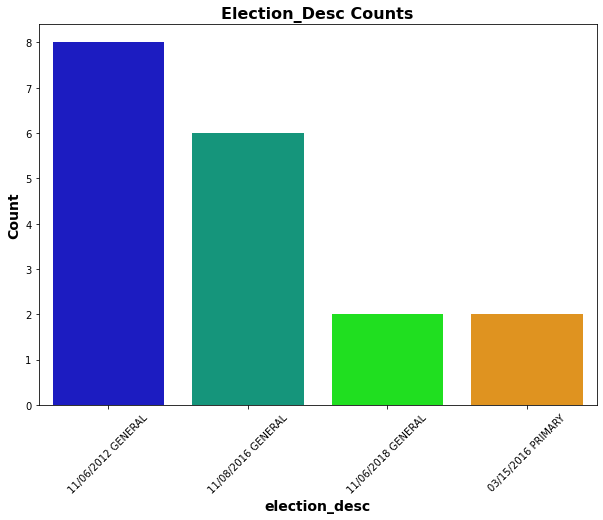

In [199]:
plot_count('election_desc', dup_ncid_elecs, rotation=45);

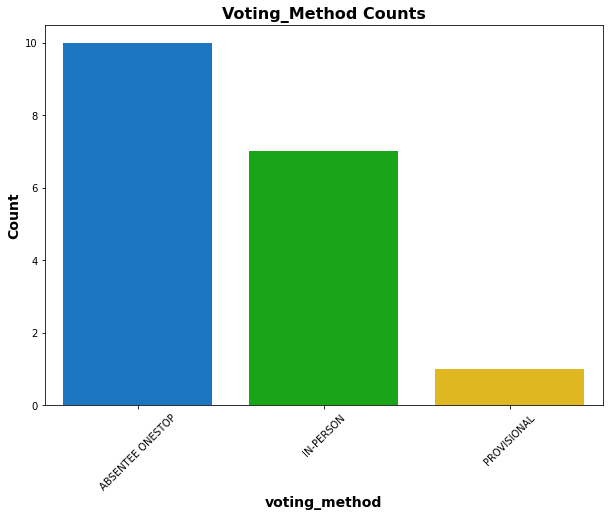

In [200]:
plot_count('voting_method', dup_ncid_elecs, rotation=45);

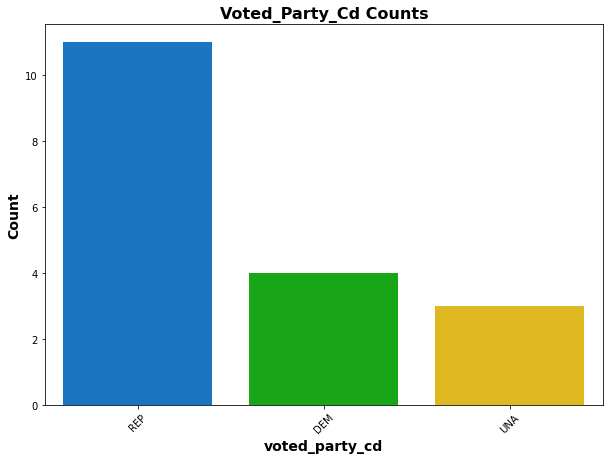

In [201]:
plot_count('voted_party_cd', dup_ncid_elecs, rotation=45);

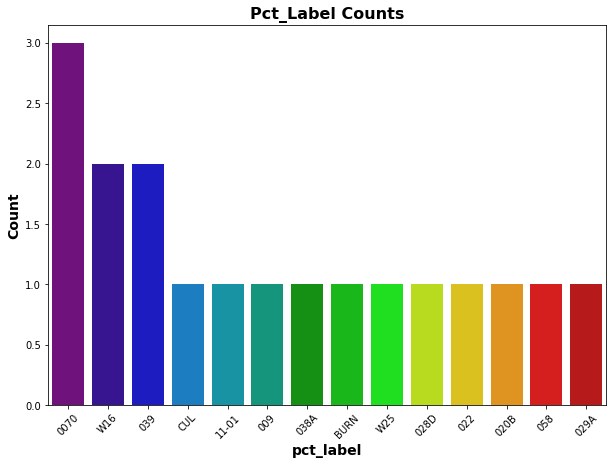

In [202]:
plot_count('pct_label', dup_ncid_elecs, rotation=45);

### Explore Voter Registration Records

In [203]:
## Check number of unique individuals represented in voter reg records
uc_vreg['ncid'].nunique()

185008

In [204]:
## Check voter status information -- Should any categories be removed??
uc_vreg['voter_status_desc'].value_counts()

ACTIVE       155227
INACTIVE      14748
REMOVED       13554
DENIED         1356
TEMPORARY       123
Name: voter_status_desc, dtype: int64

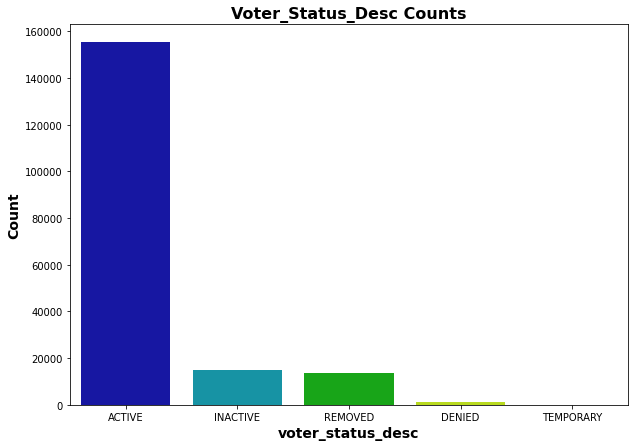

In [205]:
plot_count('voter_status_desc', uc_vreg);

In [206]:
import plotly.express as px

title_dict = {
        'font' : {
            'family':'Arial Black',
            'size':24
        }
    }

ax_title_font_dict = {
    'family':'Arial Black',
    'size':18
}

ax_tick_font_dict = {
    'family':'Arial Black',
    'size':15
}


fig = px.histogram(uc_vreg, 'voter_status_desc',
                   color='voter_status_desc',
                   title='Distribution of Voter Registration Status',
                   template='seaborn', width=750, height=500,
                   labels={
                       'voter_status_desc': 'Registration Status'
                   })

fig.update_layout(title=title_dict,
                  showlegend=False)

fig.update_yaxes(
        title_font=ax_title_font_dict,
        tickfont=ax_tick_font_dict#,
#         text='Number of Registered Voters'
    )

fig.update_xaxes(
    title_font=ax_title_font_dict,
    tickfont=ax_tick_font_dict
)
# fig.write_html('Figures/plotly_explore/vreg_status_distr.html')
fig.show()

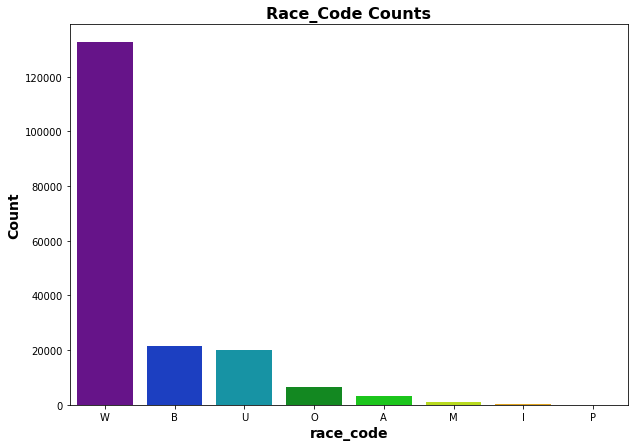

In [207]:
plot_count('race_code', uc_vreg);

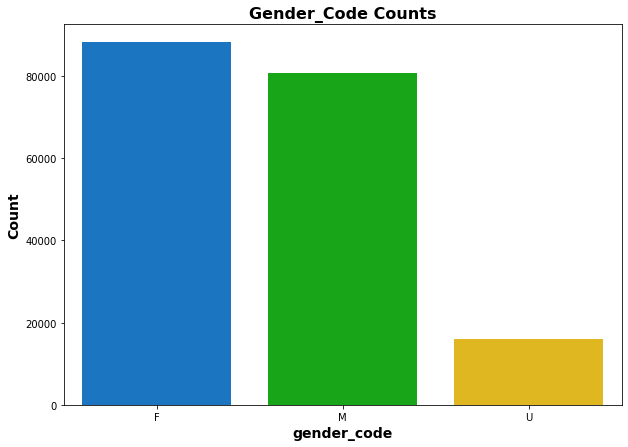

In [208]:
plot_count('gender_code', uc_vreg);

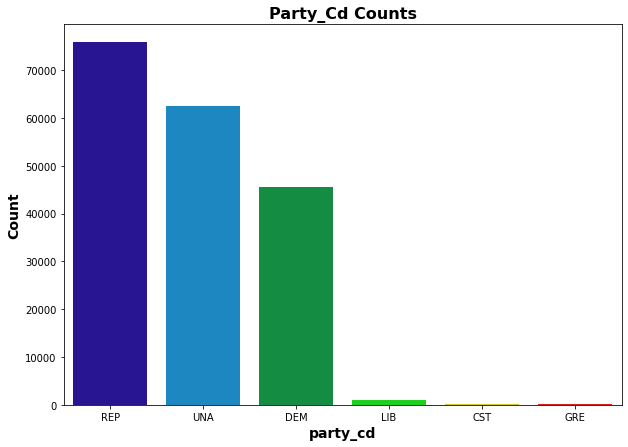

In [209]:
plot_count('party_cd', uc_vreg); # registered party

In [210]:
uc_vreg['birth_year'].min()

1907

In [211]:
uc_vreg['birth_year'].sort_values()[:10]

1488      1907
176595    1910
154566    1912
157817    1912
65965     1912
70429     1912
55363     1913
55299     1913
111685    1913
149172    1913
Name: birth_year, dtype: int64

Text(0, 0.5, 'Count')

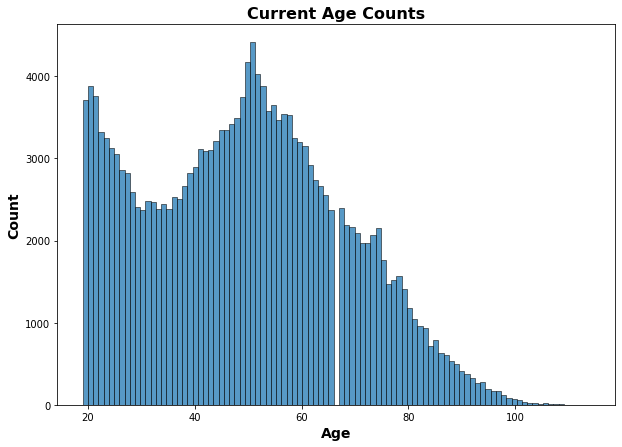

In [212]:
## Plot distribution of current age as of EOY 2020 
  ## Note that the birth_age column in uc_vreg is specific to the date that
    ## individual registered to vote, so not reflective of current age
plt.figure(figsize=(10,7))
ax = sns.histplot(uc_vreg['birth_age'])
ax.set_title('Current Age Counts', fontsize=16, weight='bold')
ax.set_xlabel('Age', fontsize=14, weight='bold')
ax.set_ylabel('Count', fontsize=14, weight='bold')

In [213]:
uc_vreg.loc[uc_vreg['birth_state']=='NO']

county_id county_desc  voter_reg_num status_cd voter_status_desc  \
76417         90       UNION         260882         A            ACTIVE   

      reason_cd voter_status_reason_desc absent_ind name_prefx_cd   last_name  \
76417        AV                 VERIFIED                           HOLSHOUSER   

      first_name middle_name name_suffix_lbl res_street_address res_city_desc  \
76417     HUNTER       SCOTT             NaN  517 W BRIEF RD     INDIAN TRAIL   

      state_cd  zip_code      mail_addr1 mail_addr2 mail_addr3 mail_addr4  \
76417       NC   28079.0  517 W BRIEF RD        NaN        NaN        NaN   

          mail_city mail_state mail_zipcode  full_phone_number race_code  \
76417  INDIAN TRAIL         NC        28079                NaN         W   

      ethnic_code party_cd gender_code  birth_age birth_state drivers_lic  \
76417          NL      REP           M         27          NO           Y   

       registr_dt precinct_abbrv precinct_desc  municipality_abbrv  \
76417  05/18/2010            032           032                93.0   

      municipality_desc  ward_abbrv  ward_desc  cong_dist_abbrv  \
76417          FAIRVIEW         NaN        NaN              9.0   

      super_court_abbrv judic_dist_abbrv  nc_senate_abbrv  nc_house_abbrv  \
76417               20B              20C             36.0            69.0   

       county_commiss_abbrv  county_commiss_desc  township_abbrv  \
76417                   NaN                  NaN             NaN   

       township_desc  school_dist_abbrv school_dist_desc  fire_dist_abbrv  \
76417            NaN                4.0        SCHOOL #4              NaN   

       fire_dist_desc  water_dist_abbrv  water_dist_desc  sewer_dist_abbrv  \
76417             NaN               NaN              NaN               NaN   

       sewer_dist_desc  sanit_dist_abbrv  sanit_dist_desc  rescue_dist_abbrv  \
76417              NaN               NaN              NaN                NaN   

       rescue_dist_desc  munic_dist_abbrv munic_dist_desc  dist_1_abbrv  \
76417               NaN              93.0        FAIRVIEW          30.0   

              dist_1_desc dist_2_abbrv dist_2_desc confidential_ind  \
76417  30TH PROSECUTORIAL                                         N   

       birth_year      ncid vtd_abbrv vtd_desc  
76417        1994  EF171044       032      032

### Active Voters

In [214]:
active_voters = uc_vreg.groupby('voter_status_desc').get_group('ACTIVE')
print(len(active_voters))
active_voters.head()

155227


county_id county_desc  voter_reg_num status_cd voter_status_desc reason_cd  \
0         90       UNION         346446         A            ACTIVE        AV   
1         90       UNION         348004         A            ACTIVE        AV   
2         90       UNION         281016         A            ACTIVE        AV   
3         90       UNION         288489         A            ACTIVE        AV   
4         90       UNION         279308         A            ACTIVE        AV   

  voter_status_reason_desc absent_ind name_prefx_cd last_name first_name  \
0                 VERIFIED                             AALAEI       ARIO   
1                 VERIFIED                             AALAEI    KAVITHA   
2                 VERIFIED                            AALBORG     ALEXIS   
3                 VERIFIED                            AALBORG      BRYAN   
4                 VERIFIED                            AALBORG     SHARON   

    middle_name name_suffix_lbl         res_street_address res_city_desc  \
0           NaN             NaN   4009  MILLBRIDGE PKWY           WAXHAW   
1           NaN             NaN   4009  MILLBRIDGE PKWY           WAXHAW   
2         LEANN             NaN  1001  STEVENS PRIDE CT     INDIAN TRAIL   
3           LEE             NaN  1001  STEVENS PRIDE CT     INDIAN TRAIL   
4  SCHLEENBAKER             NaN  1001  STEVENS PRIDE CT     INDIAN TRAIL   

  state_cd  zip_code             mail_addr1 mail_addr2 mail_addr3 mail_addr4  \
0       NC   28173.0   4009 MILLBRIDGE PKWY        NaN        NaN        NaN   
1       NC   28173.0   4009 MILLBRIDGE PKWY        NaN        NaN        NaN   
2       NC   28079.0  1001 STEVENS PRIDE CT        NaN        NaN        NaN   
3       NC   28079.0  1001 STEVENS PRIDE CT        NaN        NaN        NaN   
4       NC   28079.0  1001 STEVENS PRIDE CT        NaN        NaN        NaN   

      mail_city mail_state mail_zipcode  full_phone_number race_code  \
0        WAXHAW         NC        28173                NaN         W   
1        WAXHAW         NC        28173                NaN         A   
2  INDIAN TRAIL         NC        28079                NaN         W   
3  INDIAN TRAIL         NC        28079                NaN         W   
4  INDIAN TRAIL         NC        28079                NaN         W   

  ethnic_code party_cd gender_code  birth_age birth_state drivers_lic  \
0          NL      UNA           M         47          OC           Y   
1          NL      DEM           F         47          OC           Y   
2          NL      UNA           F         27          IA           Y   
3          UN      UNA           M         63          OK           Y   
4          NL      REP           F         63          PA           Y   

   registr_dt precinct_abbrv precinct_desc  municipality_abbrv  \
0  04/25/2019           020A          020A                 5.0   
1  06/24/2019           020A          020A                 5.0   
2  11/04/2013           029A          029A                 6.0   
3  09/17/2014           029A          029A                 6.0   
4  07/24/2013           029A          029A                 6.0   

  municipality_desc  ward_abbrv  ward_desc  cong_dist_abbrv super_court_abbrv  \
0            WAXHAW         NaN        NaN              9.0               20B   
1            WAXHAW         NaN        NaN              9.0               20B   
2      INDIAN TRAIL         NaN        NaN              9.0               20B   
3      INDIAN TRAIL         NaN        NaN              9.0               20B   
4      INDIAN TRAIL         NaN        NaN              9.0               20B   

  judic_dist_abbrv  nc_senate_abbrv  nc_house_abbrv  county_commiss_abbrv  \
0              20C             35.0            68.0                   NaN   
1              20C             35.0            68.0                   NaN   
2              20C             35.0            68.0                   NaN   
3              20C             35.0            68.0      

In [215]:
active_voters['voter_status_reason_desc'].value_counts()

VERIFIED                               151844
LEGACY DATA                              2317
UNVERIFIED NEW                            517
UNVERIFIED                                291
CONFIRMATION PENDING                      171
VERIFICATION PENDING                       40
CONFIRMATION NOT RETURNED                  26
CONFIRMATION RETURNED UNDELIVERABLE        20
ARMED FORCES                                1
Name: voter_status_reason_desc, dtype: int64

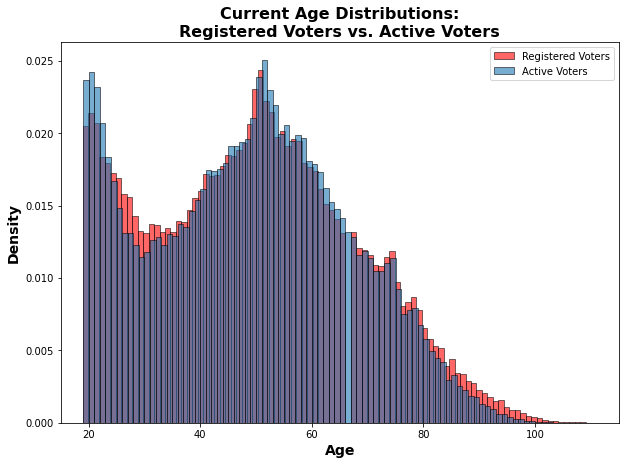

In [216]:
compare_age_distr(uc_vreg, 'Registered Voters', 
                  active_voters, 'Active Voters');

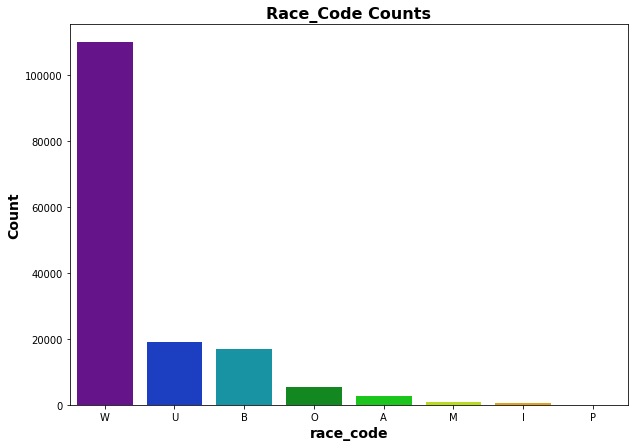

In [217]:
plot_count('race_code', active_voters);

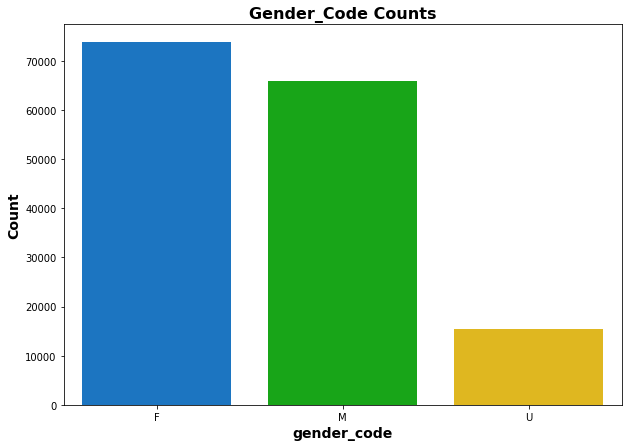

In [218]:
plot_count('gender_code', active_voters);

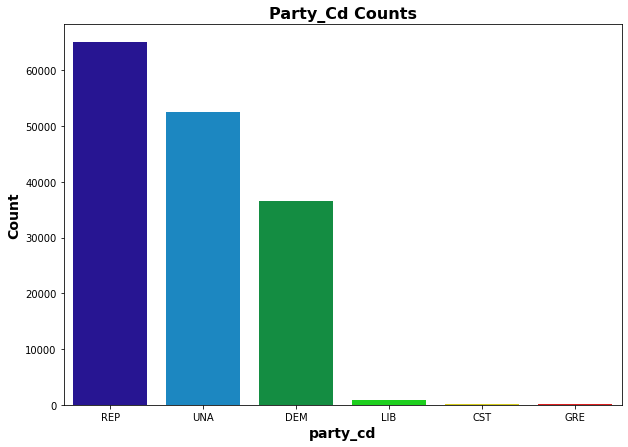

In [219]:
plot_count('party_cd', active_voters);

### Denied Voters

In [220]:
denied_voters = uc_vreg.groupby('voter_status_desc').get_group('DENIED')
print(len(denied_voters))
denied_voters.head()

1356


county_id county_desc  voter_reg_num status_cd voter_status_desc  \
124         90       UNION         265544         D            DENIED   
330         90       UNION         365813         D            DENIED   
529         90       UNION         241596         D            DENIED   
581         90       UNION         199199         D            DENIED   
596         90       UNION         318111         D            DENIED   

    reason_cd             voter_status_reason_desc absent_ind name_prefx_cd  \
124        DU  VERIFICATION RETURNED UNDELIVERABLE                            
330        DU  VERIFICATION RETURNED UNDELIVERABLE                            
529        DU  VERIFICATION RETURNED UNDELIVERABLE                            
581        DU  VERIFICATION RETURNED UNDELIVERABLE                            
596        DU  VERIFICATION RETURNED UNDELIVERABLE                            

       last_name first_name middle_name name_suffix_lbl  \
124  ABDELRAHMAN     SAMIRA        IMAD             NaN   
330      ABSHERE  CHRISTINE         MAE             NaN   
529        ADAMO     ANGELO         NaN             NaN   
581        ADAMS     CHERYL      YVONNE             NaN   
596        ADAMS    DANIELE   ELIZABETH             NaN   

           res_street_address res_city_desc state_cd  zip_code  \
124  1007  MILLS HARRIS RD       MARSHVILLE       NC   28103.0   
330  1516  MILLS HARRIS RD          WINGATE       NC   28174.0   
529      1003  SANDBOX CIR     INDIAN TRAIL       NC   28079.0   
581         4909 E HWY 74           WINGATE       NC   28174.0   
596   3300  BROOKSTONE TRL     INDIAN TRAIL       NC   28079.0   

               mail_addr1 mail_addr2 mail_addr3 mail_addr4     mail_city  \
124  1007 MILLS HARRIS RD        NaN        NaN        NaN    MARSHVILLE   
330  1516 MILLS HARRIS RD        NaN        NaN        NaN       WINGATE   
529      1003 SANDBOX CIR        NaN        NaN        NaN  INDIAN TRAIL   
581         4909 E HWY 74        NaN        NaN        NaN       WINGATE   
596   3300 BROOKSTONE TRL        NaN        NaN        NaN  INDIAN TRAIL   

    mail_state mail_zipcode  full_phone_number race_code ethnic_code party_cd  \
124         NC        28103                NaN         B          NL      UNA   
330         NC        28174                NaN         U          UN      REP   
529         NC        28079                NaN         W          NL      UNA   
581         NC        28174                NaN         W          NL      UNA   
596         NC        28079                NaN         W          NL      UNA   

    gender_code  birth_age birth_state drivers_lic  registr_dt precinct_abbrv  \
124           F         29          NC           Y  07/27/2012            NaN   
330           U         60         NaN           Y  08/06/2020            NaN   
529           M         77          OC           Y  05/01/2009            NaN   
581           F         50          TX           Y  08/03/2005            NaN   
596           F         32          OC           Y  10/29/2016            NaN   

    precinct_desc  municipality_abbrv municipality_desc  ward_abbrv  \
124           NaN                 NaN               NaN         NaN   
330           NaN                 NaN               NaN         NaN   
529           NaN                 NaN               NaN         NaN   
581           NaN                 NaN               NaN         NaN   
596           NaN                 NaN               NaN         NaN   

     ward_desc  cong_dist_abbrv super_court_abbrv judic_dist_abbrv  \
124        NaN              NaN               NaN              NaN   
330        NaN              NaN               NaN              NaN   
529        NaN              NaN               NaN              NaN   
581        NaN              NaN               NaN              NaN   
596        NaN              NaN               NaN              NaN   

     nc_senate_abbrv  nc_house_abbrv  county_commiss_abbrv  

In [221]:
denied_voters['voter_status_reason_desc'].value_counts()

VERIFICATION RETURNED UNDELIVERABLE    1356
Name: voter_status_reason_desc, dtype: int64

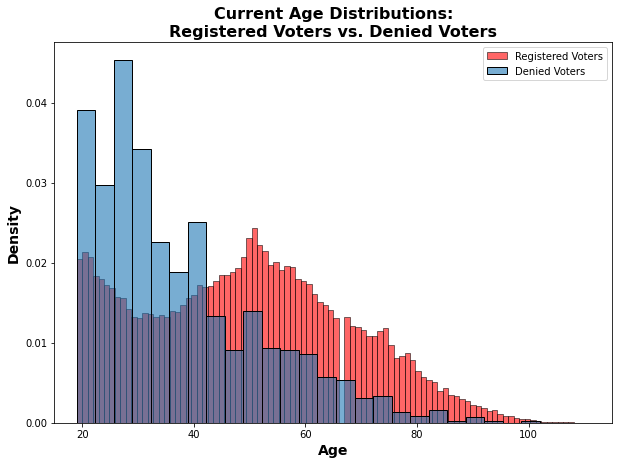

In [222]:
compare_age_distr(uc_vreg, 'Registered Voters', 
                  denied_voters, 'Denied Voters');

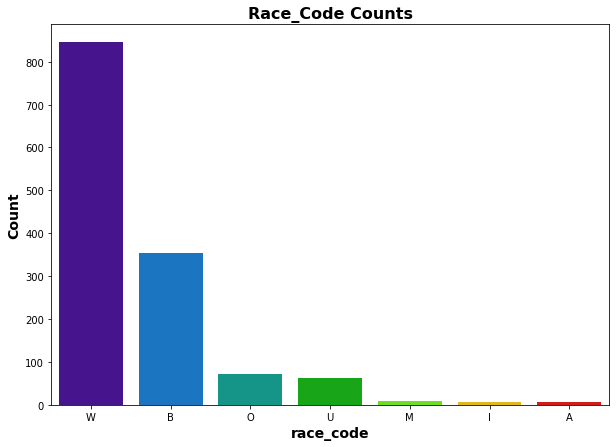

In [223]:
plot_count('race_code', denied_voters);

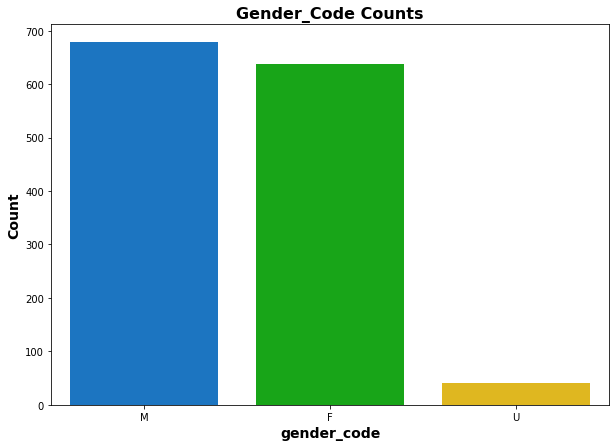

In [224]:
plot_count('gender_code', denied_voters);

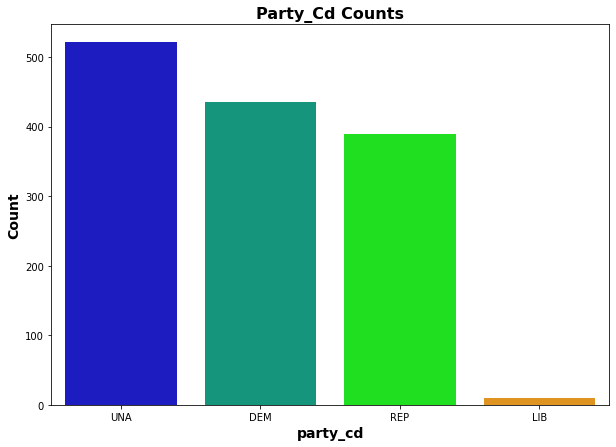

In [225]:
plot_count('party_cd', denied_voters);

### Inactive Voters

In [226]:
inactive_voters = uc_vreg.groupby('voter_status_desc').get_group('INACTIVE')
print(len(inactive_voters))
inactive_voters.head()

14748


county_id county_desc  voter_reg_num status_cd voter_status_desc  \
21         90       UNION         283607         I          INACTIVE   
35         90       UNION         304093         I          INACTIVE   
45         90       UNION         200444         I          INACTIVE   
87         90       UNION         240783         I          INACTIVE   
90         90       UNION         236007         I          INACTIVE   

   reason_cd   voter_status_reason_desc absent_ind name_prefx_cd  \
21        IN  CONFIRMATION NOT RETURNED                            
35        IN  CONFIRMATION NOT RETURNED                            
45        IN  CONFIRMATION NOT RETURNED                            
87        IN  CONFIRMATION NOT RETURNED                            
90        IN  CONFIRMATION NOT RETURNED                            

         last_name first_name middle_name name_suffix_lbl  \
21            ABAR    KRISTEN      ELAINE             NaN   
35  ABARCA-NICOLAS       JOSE     ALBERTO             NaN   
45           ABBAS       OMAR     MOHAMED             NaN   
87          ABBOTT       MARY         SUE             NaN   
90          ABBOTT       NEIL         NaN             NaN   

               res_street_address res_city_desc state_cd  zip_code  \
21             5523  CHERAW RD       MARSHVILLE       NC   28103.0   
35               616  JONES ST           MONROE       NC   28110.0   
45  2206  HONEYCUTT SIMPSON RD           MONROE       NC   28110.0   
87              4122  EUTAW DR           WAXHAW       NC   28173.0   
90           5127  CRUZ BAY DR           MONROE       NC   28110.0   

                   mail_addr1 mail_addr2 mail_addr3 mail_addr4   mail_city  \
21             5523 CHERAW RD        NaN        NaN        NaN  MARSHVILLE   
35               616 JONES ST        NaN        NaN        NaN      MONROE   
45  2206 HONEYCUTT SIMPSON RD        NaN        NaN        NaN      MONROE   
87              4122 EUTAW DR        NaN        NaN        NaN      WAXHAW   
90           5127 CRUZ BAY DR        NaN        NaN        NaN      MONROE   

   mail_state mail_zipcode  full_phone_number race_code ethnic_code party_cd  \
21         NC        28103                NaN         W          NL      DEM   
35         NC        28110                NaN         O          NL      UNA   
45         NC        28110                NaN         O          UN      UNA   
87         NC        28173                NaN         W          NL      UNA   
90         NC        28110                NaN         W          UN      UNA   

   gender_code  birth_age birth_state drivers_lic  registr_dt precinct_abbrv  \
21           F         25          NC           Y  02/17/2014            026   
35           M         23          NC           Y  04/26/2016            004   
45           M         34          NJ           Y  10/03/2005            013   
87           F         41          WV           Y  03/04/2009           020A   
90           U         42         NaN           Y  10/10/2008            031   

   precinct_desc  municipality_abbrv municipality_desc  ward_abbrv  ward_desc  \
21           026                 NaN               NaN         NaN        NaN   
35           004                 2.0            MONROE         NaN        NaN   
45           013                98.0        UNIONVILLE         NaN        NaN   
87          020A                 5.0            WAXHAW         NaN        NaN   
90           031                 NaN               NaN         NaN        NaN   

    cong_dist_abbrv super_court_abbrv judic_dist_abbrv  nc_senate_abbrv  \
21              9.0               20B              20C             35.0   
35              9.0               20B              20B             35.0   
45              9.0               20B              20B             35.0   
87              9.0               20B              20C             35.0   
90              9.0               20B              20C             35.0   

    n

In [227]:
inactive_voters['voter_status_reason_desc'].value_counts()

CONFIRMATION NOT RETURNED              9333
CONFIRMATION RETURNED UNDELIVERABLE    5414
ADMINISTRATIVE                            1
Name: voter_status_reason_desc, dtype: int64

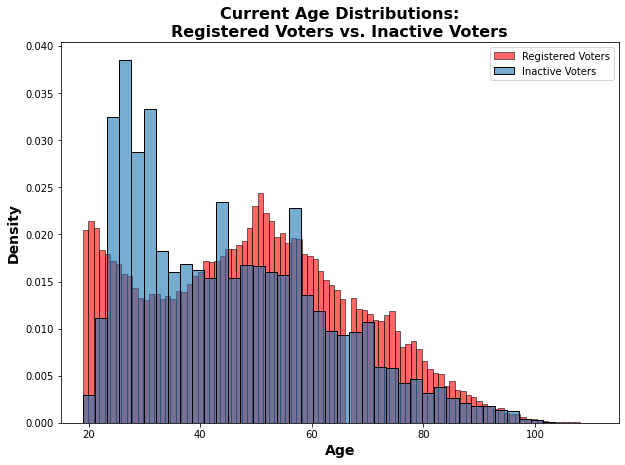

In [228]:
compare_age_distr(uc_vreg, 'Registered Voters', 
                  inactive_voters, 'Inactive Voters');

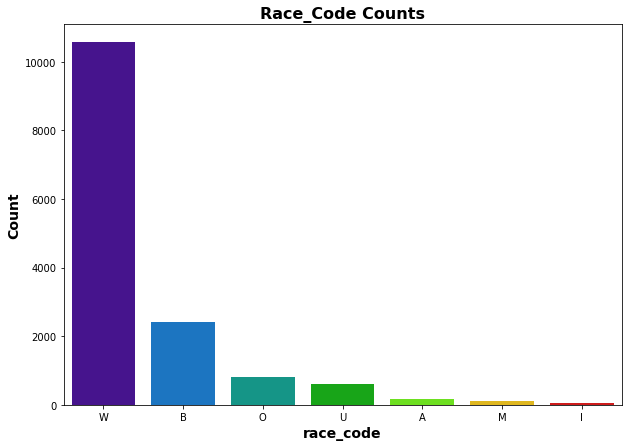

In [229]:
plot_count('race_code', inactive_voters);

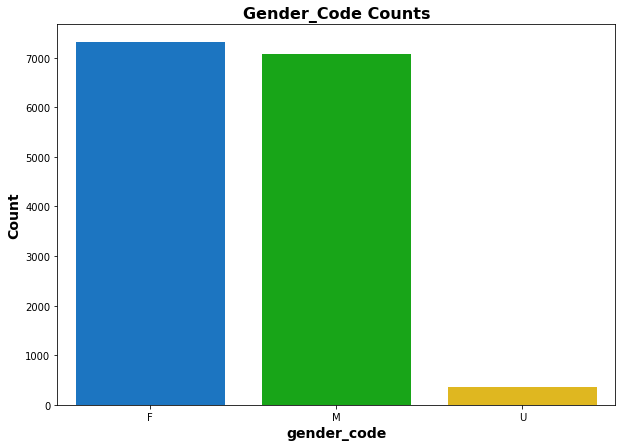

In [230]:
plot_count('gender_code', inactive_voters);

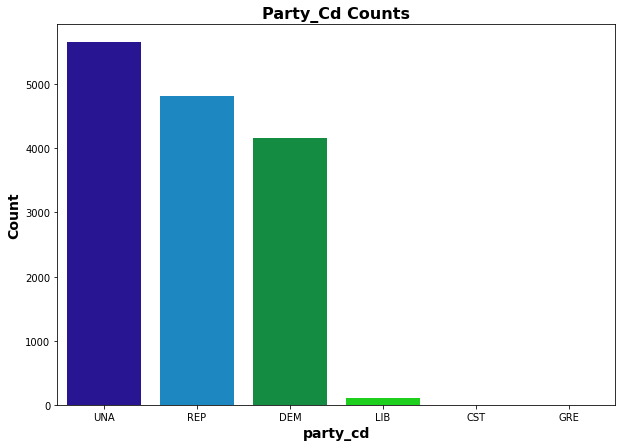

In [231]:
plot_count('party_cd', inactive_voters);

### Removed Voters

In [232]:
removed_voters = uc_vreg.groupby('voter_status_desc').get_group('REMOVED')
print(len(removed_voters))
removed_voters.head()

13554


county_id county_desc  voter_reg_num status_cd voter_status_desc  \
20         90       UNION         259695         R           REMOVED   
62         90       UNION         243470         R           REMOVED   
68         90       UNION         190348         R           REMOVED   
73         90       UNION         157042         R           REMOVED   
78         90       UNION         262940         R           REMOVED   

   reason_cd                           voter_status_reason_desc absent_ind  \
20        RM  REMOVED AFTER 2 FED GENERAL ELECTIONS IN INACT...              
62        RL                                  MOVED FROM COUNTY              
68        RS                                   MOVED FROM STATE              
73        RD                                           DECEASED              
78        RM  REMOVED AFTER 2 FED GENERAL ELECTIONS IN INACT...              

   name_prefx_cd last_name first_name middle_name name_suffix_lbl  \
20                    ABAR      JAMES   FREDERICK                   
62                   ABBEN     LAURIN     DOROTHY                   
68                  ABBOTT       ALAN      WALTER                   
73                  ABBOTT    CHARLES         NaN                   
78                  ABBOTT     HARLEY    CHEYENNE                   

   res_street_address res_city_desc state_cd  zip_code mail_addr1 mail_addr2  \
20            REMOVED           NaN      NaN       NaN                         
62            REMOVED           NaN      NaN       NaN                         
68            REMOVED           NaN      NaN       NaN                         
73            REMOVED           NaN      NaN       NaN                         
78            REMOVED           NaN      NaN       NaN                         

   mail_addr3 mail_addr4 mail_city mail_state mail_zipcode  full_phone_number  \
20                                                                        NaN   
62                                                                        NaN   
68                                                                        NaN   
73                                                                        NaN   
78                                                                        NaN   

   race_code ethnic_code party_cd gender_code  birth_age birth_state  \
20         W          NL      REP           M         50          MI   
62         W          NL      REP           F         30          FL   
68         W          NL      REP           M         53          NY   
73         B          NL      DEM           M         62         NaN   
78         W          NL      DEM           F         28          WV   

   drivers_lic  registr_dt precinct_abbrv precinct_desc  municipality_abbrv  \
20           Y  02/09/2012            NaN           NaN                 NaN   
62           N  09/01/2009            NaN           NaN                 NaN   
68           Y  09/15/2004            NaN           NaN                 NaN   
73           Y  06/12/2000            NaN           NaN                 NaN   
78           Y  07/10/2012            NaN           NaN                 NaN   

   municipality_desc  ward_abbrv  ward_desc  cong_dist_abbrv  \
20               NaN         NaN        NaN              NaN   
62               NaN         NaN        NaN              NaN   
68               NaN         NaN        NaN              NaN   
73               NaN         NaN        NaN              NaN   
78               NaN         NaN        NaN              NaN   

   super_court_abbrv judic_dist_abbrv  nc_senate_abbrv  nc_house_abbrv  \
20               NaN              NaN              NaN             NaN   
62               NaN              NaN              NaN             NaN   
68               NaN              NaN              NaN             NaN   
73               NaN              NaN              NaN             NaN   
78               NaN              NaN              NaN  

In [233]:
removed_voters['voter_status_reason_desc'].value_counts()

DECEASED                                                    6179
MOVED FROM STATE                                            3720
REMOVED AFTER 2 FED GENERAL ELECTIONS IN INACTIVE STATUS    1569
MOVED FROM COUNTY                                           1418
MOVED WITHIN STATE                                           169
FELONY SENTENCE COMPLETED                                    158
REQUEST FROM VOTER                                           126
FELONY CONVICTION                                            110
TEMPORARY REGISTRANT                                          73
DUPLICATE                                                     27
ADMINISTRATIVE                                                 5
Name: voter_status_reason_desc, dtype: int64

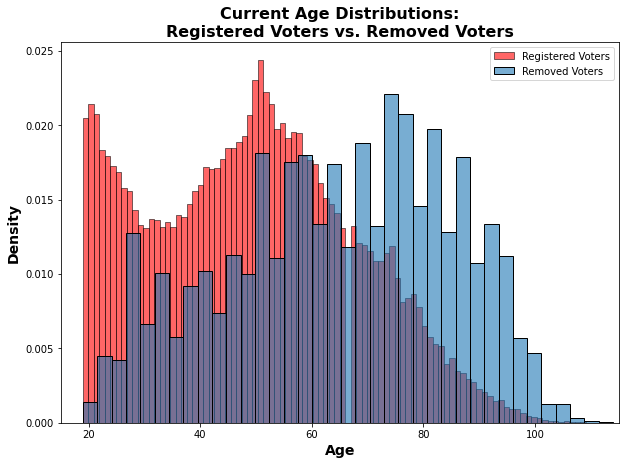

In [234]:
compare_age_distr(uc_vreg, 'Registered Voters', 
                  removed_voters, 'Removed Voters');

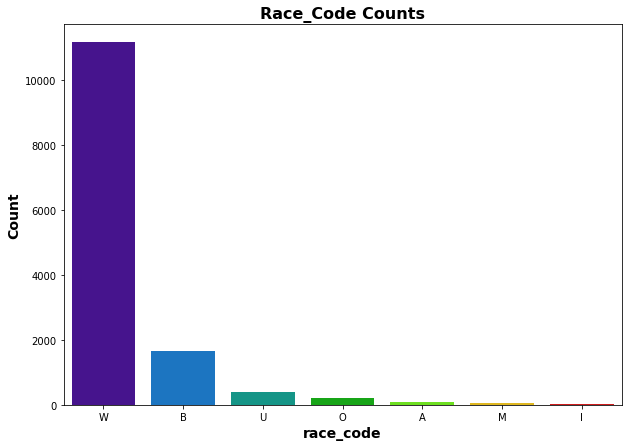

In [235]:
plot_count('race_code', removed_voters);

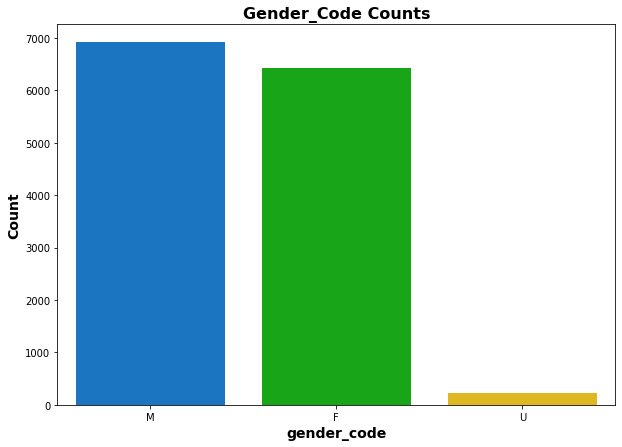

In [236]:
plot_count('gender_code', removed_voters);

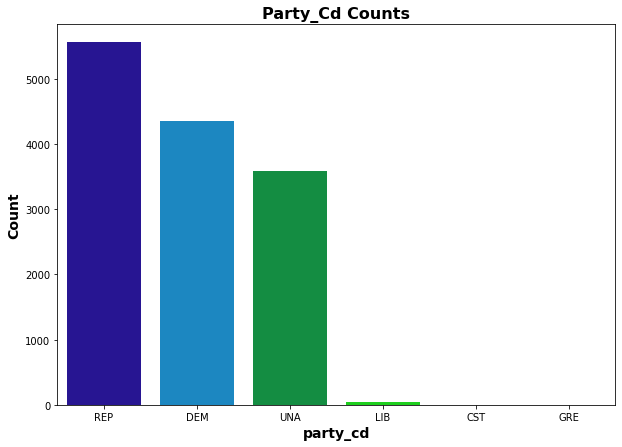

In [237]:
plot_count('party_cd', removed_voters);

## Merge Voter Registration Data with Voter History Data

In [238]:
## Merge voter registration information onto records of voter history based 
  ## on unique ncid
    
## Use right join so we're only including ncid's for which their is
  ## registration and demographic information, including for those 
    ## people who are registered, but have never voted
all_uc_voters = uc_vhis.merge(uc_vreg.drop(columns=['county_id', 'county_desc',
                                                'voter_reg_num'], axis=1),
                                       how='right', on='ncid')
# inspect new dataframe
display(all_uc_voters.head())
all_uc_voters.tail()

county_id county_desc  voter_reg_num election_lbl  \
0       90.0       UNION       346446.0   11/03/2020   
1       90.0       UNION       348004.0   11/03/2020   
2        NaN         NaN            NaN          NaN   
3       90.0       UNION       288489.0   11/08/2011   
4       90.0       UNION       288489.0   11/06/2012   

                  election_desc     voting_method voted_party_cd  \
0            11/03/2020 GENERAL  ABSENTEE ONESTOP            UNA   
1            11/03/2020 GENERAL  ABSENTEE ONESTOP            DEM   
2                           NaN               NaN            NaN   
3  11/08/2011 MUNICIPAL GENERAL         IN-PERSON            UNA   
4            11/06/2012 GENERAL  ABSENTEE ONESTOP            UNA   

  voted_party_desc pct_label pct_description      ncid  voted_county_id  \
0     UNAFFILIATED      020A            020A  EF230133             90.0   
1       DEMOCRATIC      020A            020A  EF231096             90.0   
2              NaN       NaN             NaN  AL261840              NaN   
3     UNAFFILIATED      26.1            26.1  AL178177             11.0   
4     UNAFFILIATED      26.1            26.1  AL178177             11.0   

  voted_county_desc vtd_label vtd_description status_cd voter_status_desc  \
0             UNION      020A            020A         A            ACTIVE   
1             UNION      020A            020A         A            ACTIVE   
2               NaN       NaN             NaN         A            ACTIVE   
3          BUNCOMBE      26.1            26.1         A            ACTIVE   
4          BUNCOMBE      26.1            26.1         A            ACTIVE   

  reason_cd voter_status_reason_desc absent_ind name_prefx_cd last_name  \
0        AV                 VERIFIED                             AALAEI   
1        AV                 VERIFIED                             AALAEI   
2        AV                 VERIFIED                            AALBORG   
3        AV                 VERIFIED                            AALBORG   
4        AV                 VERIFIED                            AALBORG   

  first_name middle_name name_suffix_lbl         res_street_address  \
0       ARIO         NaN             NaN   4009  MILLBRIDGE PKWY      
1    KAVITHA         NaN             NaN   4009  MILLBRIDGE PKWY      
2     ALEXIS       LEANN             NaN  1001  STEVENS PRIDE CT      
3      BRYAN         LEE             NaN  1001  STEVENS PRIDE CT      
4      BRYAN         LEE             NaN  1001  STEVENS PRIDE CT      

  res_city_desc state_cd  zip_code             mail_addr1 mail_addr2  \
0        WAXHAW       NC   28173.0   4009 MILLBRIDGE PKWY        NaN   
1        WAXHAW       NC   28173.0   4009 MILLBRIDGE PKWY        NaN   
2  INDIAN TRAIL       NC   28079.0  1001 STEVENS PRIDE CT        NaN   
3  INDIAN TRAIL       NC   28079.0  1001 STEVENS PRIDE CT        NaN   
4  INDIAN TRAIL       NC   28079.0  1001 STEVENS PRIDE CT        NaN   

  mail_addr3 mail_addr4     mail_city mail_state mail_zipcode  \
0        NaN        NaN        WAXHAW         NC        28173   
1        NaN        NaN        WAXHAW         NC        28173   
2        NaN        NaN  INDIAN TRAIL         NC        28079   
3        NaN        NaN  INDIAN TRAIL         NC        28079   
4        NaN        NaN  INDIAN TRAIL         NC        28079   

   full_phone_number race_code ethnic_code party_cd gender_code  birth_age  \
0                NaN         W          NL      UNA           M         47   
1                NaN         A          NL      DEM           F         47   
2                NaN         W          NL      UNA           F         27   
3                NaN         W          UN      UNA           M         63   
4                NaN         W          UN      UNA           M         63   

  birth_state drivers_lic  registr_dt precinct_abbrv precinct_desc  \
0          OC           Y  04/25/2019           020A          020A   
1          OC           Y  06/24

county_id county_desc  voter_reg_num election_lbl       election_desc  \
827093       90.0       UNION       243464.0   05/08/2018  05/08/2018 PRIMARY   
827094       90.0       UNION       243464.0   09/10/2019  09/10/2019 GENERAL   
827095       90.0       UNION       243464.0   11/04/2014  11/04/2014 GENERAL   
827096       90.0       UNION       243464.0   11/08/2016  11/08/2016 GENERAL   
827097        NaN         NaN            NaN          NaN                 NaN   

           voting_method voted_party_cd voted_party_desc pct_label  \
827093  ABSENTEE ONESTOP            DEM       DEMOCRATIC       025   
827094  ABSENTEE ONESTOP            DEM       DEMOCRATIC       025   
827095  ABSENTEE ONESTOP            DEM       DEMOCRATIC       025   
827096  ABSENTEE ONESTOP            DEM       DEMOCRATIC       025   
827097               NaN            NaN              NaN       NaN   

       pct_description      ncid  voted_county_id voted_county_desc vtd_label  \
827093             025  EF157599             90.0             UNION       025   
827094             025  EF157599             90.0             UNION       025   
827095             025  EF157599             90.0             UNION       025   
827096             025  EF157599             90.0             UNION       025   
827097             NaN  EF219265              NaN               NaN       NaN   

       vtd_description status_cd voter_status_desc reason_cd  \
827093             025         A            ACTIVE        AV   
827094             025         A            ACTIVE        AV   
827095             025         A            ACTIVE        AV   
827096             025         A            ACTIVE        AV   
827097             NaN         I          INACTIVE        IU   

                   voter_status_reason_desc absent_ind name_prefx_cd  \
827093                             VERIFIED                            
827094                             VERIFIED                            
827095                             VERIFIED                            
827096                             VERIFIED                            
827097  CONFIRMATION RETURNED UNDELIVERABLE                            

       last_name first_name middle_name name_suffix_lbl  \
827093    ZYNSKY      JAMES      ROBERT             NaN   
827094    ZYNSKY      JAMES      ROBERT             NaN   
827095    ZYNSKY      JAMES      ROBERT             NaN   
827096    ZYNSKY      JAMES      ROBERT             NaN   
827097   ZYWICKI   JENNIFER         ANN             NaN   

           res_street_address res_city_desc state_cd  zip_code  \
827093     2905  MEDLIN RD           MONROE       NC   28112.0   
827094     2905  MEDLIN RD           MONROE       NC   28112.0   
827095     2905  MEDLIN RD           MONROE       NC   28112.0   
827096     2905  MEDLIN RD           MONROE       NC   28112.0   
827097  5719  PARKSTONE DR         MATTHEWS       NC   28104.0   

               mail_addr1 mail_addr2 mail_addr3 mail_addr4 mail_city  \
827093     2905 MEDLIN RD        NaN        NaN        NaN    MONROE   
827094     2905 MEDLIN RD        NaN        NaN        NaN    MONROE   
827095     2905 MEDLIN RD        NaN        NaN        NaN    MONROE   
827096     2905 MEDLIN RD        NaN        NaN        NaN    MONROE   
827097  5719 PARKSTONE DR        NaN        NaN        NaN  MATTHEWS   

       mail_state mail_zipcode  full_phone_number race_code ethnic_code  \
827093         NC        28112                NaN         W          NL   
827094         NC        28112                NaN         W          NL   
827095         NC        28112                NaN         W          NL   
827096         NC        28112                NaN         W          NL   
827097         NC        28104                NaN         W          NL   

       party_cd gender_code  birth_age birth_state drivers_lic  registr_dt  \
827093      DEM           M         69          MA           Y  08/28/2009   
827

## Drop 'Removed' and 'Denied' Voters - Further Exploration

In [239]:
## Drop voters who have been removed or had their registration denied
uc_voters = all_uc_voters.loc[all_uc_voters['voter_status_desc'] != 'REMOVED']
uc_voters = uc_voters.loc[uc_voters['voter_status_desc'] != 'DENIED']
# uc_voters.info()

In [240]:
## Check remaining number of unique individuals represented in the data
uc_voters['ncid'].nunique()

170098

## Engineer Features for Grouping/ Database Manipulation

In [241]:
## Create a new column specifying the election category based on the
  ## election description col
uc_voters.insert(loc=5, column='election_cat', 
                 value=uc_voters['election_desc'].str.split(n=1,
                                                            expand=True)[1])
# If the category was general or primary, leave as is, otherwise 'other'
uc_voters['election_cat'] = np.where(uc_voters['election_cat'].isin(
                                                    ['GENERAL', 'PRIMARY']),
                                     uc_voters['election_cat'], 'other')

In [242]:
## Recast election_lbl as datetime and create a new col for just the year
uc_voters['election_lbl'] = pd.to_datetime(uc_voters['election_lbl'])
uc_voters.insert(loc=5, column='election_yr',
                 value=uc_voters['election_lbl'].dt.year)

In [243]:
## Create a new binary variable indicating if it was a major election
uc_voters.insert(loc=7, column='major_elec',
                 value=np.where(((uc_voters['election_yr']%2 == 0) & 
                                 (uc_voters['election_cat'].isin(
                                     ['GENERAL', 'PRIMARY']))),
                                1,0))

In [244]:
## Null values in the election_desc col indicate individuals that are 
  ## registered to vote, but have not voted in a recent major election.
    ## Thus, election_cat, major_elec, and presid_elec 
    ## are irrelevant for these records
# Fill irrelevant fields with null values
uc_voters.loc[uc_voters['election_desc'].isna(),
              ['election_cat', 'major_elec']] = np.nan

# Fill with NaN with 'None' in election_desc col to preserve info for
  # registered voters without a voting history when merging df's based on 
    # ncid and election_desc below
uc_voters['election_desc'].fillna('None', inplace=True)

# Inspect updated dataframe
uc_voters.head()

county_id county_desc  voter_reg_num election_lbl  \
0       90.0       UNION       346446.0   2020-11-03   
1       90.0       UNION       348004.0   2020-11-03   
2        NaN         NaN            NaN          NaT   
3       90.0       UNION       288489.0   2011-11-08   
4       90.0       UNION       288489.0   2012-11-06   

                  election_desc  election_yr election_cat  major_elec  \
0            11/03/2020 GENERAL       2020.0      GENERAL         1.0   
1            11/03/2020 GENERAL       2020.0      GENERAL         1.0   
2                          None          NaN          NaN         NaN   
3  11/08/2011 MUNICIPAL GENERAL       2011.0        other         0.0   
4            11/06/2012 GENERAL       2012.0      GENERAL         1.0   

      voting_method voted_party_cd voted_party_desc pct_label pct_description  \
0  ABSENTEE ONESTOP            UNA     UNAFFILIATED      020A            020A   
1  ABSENTEE ONESTOP            DEM       DEMOCRATIC      020A            020A   
2               NaN            NaN              NaN       NaN             NaN   
3         IN-PERSON            UNA     UNAFFILIATED      26.1            26.1   
4  ABSENTEE ONESTOP            UNA     UNAFFILIATED      26.1            26.1   

       ncid  voted_county_id voted_county_desc vtd_label vtd_description  \
0  EF230133             90.0             UNION      020A            020A   
1  EF231096             90.0             UNION      020A            020A   
2  AL261840              NaN               NaN       NaN             NaN   
3  AL178177             11.0          BUNCOMBE      26.1            26.1   
4  AL178177             11.0          BUNCOMBE      26.1            26.1   

  status_cd voter_status_desc reason_cd voter_status_reason_desc absent_ind  \
0         A            ACTIVE        AV                 VERIFIED              
1         A            ACTIVE        AV                 VERIFIED              
2         A            ACTIVE        AV                 VERIFIED              
3         A            ACTIVE        AV                 VERIFIED              
4         A            ACTIVE        AV                 VERIFIED              

  name_prefx_cd last_name first_name middle_name name_suffix_lbl  \
0                  AALAEI       ARIO         NaN             NaN   
1                  AALAEI    KAVITHA         NaN             NaN   
2                 AALBORG     ALEXIS       LEANN             NaN   
3                 AALBORG      BRYAN         LEE             NaN   
4                 AALBORG      BRYAN         LEE             NaN   

          res_street_address res_city_desc state_cd  zip_code  \
0   4009  MILLBRIDGE PKWY           WAXHAW       NC   28173.0   
1   4009  MILLBRIDGE PKWY           WAXHAW       NC   28173.0   
2  1001  STEVENS PRIDE CT     INDIAN TRAIL       NC   28079.0   
3  1001  STEVENS PRIDE CT     INDIAN TRAIL       NC   28079.0   
4  1001  STEVENS PRIDE CT     INDIAN TRAIL       NC   28079.0   

              mail_addr1 mail_addr2 mail_addr3 mail_addr4     mail_city  \
0   4009 MILLBRIDGE PKWY        NaN        NaN        NaN        WAXHAW   
1   4009 MILLBRIDGE PKWY        NaN        NaN        NaN        WAXHAW   
2  1001 STEVENS PRIDE CT        NaN        NaN        NaN  INDIAN TRAIL   
3  1001 STEVENS PRIDE CT        NaN        NaN        NaN  INDIAN TRAIL   
4  1001 STEVENS PRIDE CT        NaN        NaN        NaN  INDIAN TRAIL   

  mail_state mail_zipcode  full_phone_number race_code ethnic_code party_cd  \
0         NC        28173                NaN         W          NL      UNA   
1         NC        28173                NaN         A          NL      DEM   
2         NC        28079                NaN         W          NL      UNA   
3         NC        28079                NaN         W          UN      UNA   
4         NC        28079                NaN         W          UN      UNA   

  gender_code  birth_age birth_state drivers_lic  registr_dt precinct_abbrv  \
0  

In [245]:
## Check number of unique individuals represented by the data
uc_voters['ncid'].nunique()

170098

In [246]:
## Store index of non-major and non-null election types
other_elec_idx = uc_voters.loc[uc_voters['election_cat']=='other'].index

## Create a df containing only major and null elections
major_elec_df = uc_voters.drop(index=other_elec_idx)

# Check number of unique individuals that voted in a recent major election, 
  # plus those with no voting history
print(major_elec_df['ncid'].nunique())

# 131 registered voters voted in a non-major election, but no major elections
uc_voters['ncid'].nunique() - major_elec_df['ncid'].nunique()

169967


131

## Merge DataFrames - Focus on Recent Major Elections

In [247]:
## Get list of unique ncids
uc_ncid_list = list(uc_voters['ncid'].unique())

## Get list of unique election descriptions
major_elections = list(uc_voters.groupby('major_elec').get_group(1)['election_desc'].unique())

## Add 'None' to the list to capture individuals that have not voted in any 
  ## recent major election when merging dataframes on ncid and election_desc
elec_desc_list = major_elections + ['None']
elec_desc_list

['11/03/2020 GENERAL',
 '11/06/2012 GENERAL',
 '05/08/2012 PRIMARY',
 '03/15/2016 PRIMARY',
 '11/06/2018 GENERAL',
 '11/08/2016 GENERAL',
 '11/04/2014 GENERAL',
 '03/03/2020 PRIMARY',
 '05/08/2018 PRIMARY',
 '05/06/2014 PRIMARY',
 'None']

In [248]:
## Create multiindex that lists every election for every registered voter
mltidx = pd.MultiIndex.from_tuples(
    [(ncid, elec) for ncid in uc_ncid_list for elec in elec_desc_list],
    names=['ncid', 'election_desc'])

## Use multiindex to create new dataframe
elecs_by_voter = pd.DataFrame(index=mltidx)

In [249]:
## Check length and inspect structure of new dataframe
print(len(elecs_by_voter))
elecs_by_voter.head(15)

1871078


Empty DataFrame
Columns: []
Index: [(EF230133, 11/03/2020 GENERAL), (EF230133, 11/06/2012 GENERAL), (EF230133, 05/08/2012 PRIMARY), (EF230133, 03/15/2016 PRIMARY), (EF230133, 11/06/2018 GENERAL), (EF230133, 11/08/2016 GENERAL), (EF230133, 11/04/2014 GENERAL), (EF230133, 03/03/2020 PRIMARY), (EF230133, 05/08/2018 PRIMARY), (EF230133, 05/06/2014 PRIMARY), (EF230133, None), (EF231096, 11/03/2020 GENERAL), (EF231096, 11/06/2012 GENERAL), (EF231096, 05/08/2012 PRIMARY), (EF231096, 03/15/2016 PRIMARY)]

In [250]:
elecs_by_voter.reset_index(inplace=True)
elecs_by_voter.head(15)

ncid       election_desc
0   EF230133  11/03/2020 GENERAL
1   EF230133  11/06/2012 GENERAL
2   EF230133  05/08/2012 PRIMARY
3   EF230133  03/15/2016 PRIMARY
4   EF230133  11/06/2018 GENERAL
5   EF230133  11/08/2016 GENERAL
6   EF230133  11/04/2014 GENERAL
7   EF230133  03/03/2020 PRIMARY
8   EF230133  05/08/2018 PRIMARY
9   EF230133  05/06/2014 PRIMARY
10  EF230133                None
11  EF231096  11/03/2020 GENERAL
12  EF231096  11/06/2012 GENERAL
13  EF231096  05/08/2012 PRIMARY
14  EF231096  03/15/2016 PRIMARY

In [251]:
## Merge voter histories using the created multiindex as the keys to join
  ## each ncid onto every election and 'None'
voter_elecs = elecs_by_voter.merge(uc_vhis, how='left',
                                   on=['ncid', 'election_desc'])
# Inspect new df
print(len(voter_elecs))
display(voter_elecs.head())
voter_elecs.tail()

1871087


ncid       election_desc  county_id county_desc  voter_reg_num  \
0  EF230133  11/03/2020 GENERAL       90.0       UNION       346446.0   
1  EF230133  11/06/2012 GENERAL        NaN         NaN            NaN   
2  EF230133  05/08/2012 PRIMARY        NaN         NaN            NaN   
3  EF230133  03/15/2016 PRIMARY        NaN         NaN            NaN   
4  EF230133  11/06/2018 GENERAL        NaN         NaN            NaN   

  election_lbl     voting_method voted_party_cd voted_party_desc pct_label  \
0   11/03/2020  ABSENTEE ONESTOP            UNA     UNAFFILIATED      020A   
1          NaN               NaN            NaN              NaN       NaN   
2          NaN               NaN            NaN              NaN       NaN   
3          NaN               NaN            NaN              NaN       NaN   
4          NaN               NaN            NaN              NaN       NaN   

  pct_description  voted_county_id voted_county_desc vtd_label vtd_description  
0            020A             90.0             UNION      020A            020A  
1             NaN              NaN               NaN       NaN             NaN  
2             NaN              NaN               NaN       NaN             NaN  
3             NaN              NaN               NaN       NaN             NaN  
4             NaN              NaN               NaN       NaN             NaN

ncid       election_desc  county_id county_desc  voter_reg_num  \
1871082  EF219265  11/04/2014 GENERAL        NaN         NaN            NaN   
1871083  EF219265  03/03/2020 PRIMARY        NaN         NaN            NaN   
1871084  EF219265  05/08/2018 PRIMARY        NaN         NaN            NaN   
1871085  EF219265  05/06/2014 PRIMARY        NaN         NaN            NaN   
1871086  EF219265                None        NaN         NaN            NaN   

        election_lbl voting_method voted_party_cd voted_party_desc pct_label  \
1871082          NaN           NaN            NaN              NaN       NaN   
1871083          NaN           NaN            NaN              NaN       NaN   
1871084          NaN           NaN            NaN              NaN       NaN   
1871085          NaN           NaN            NaN              NaN       NaN   
1871086          NaN           NaN            NaN              NaN       NaN   

        pct_description  voted_county_id voted_county_desc vtd_label  \
1871082             NaN              NaN               NaN       NaN   
1871083             NaN              NaN               NaN       NaN   
1871084             NaN              NaN               NaN       NaN   
1871085             NaN              NaN               NaN       NaN   
1871086             NaN              NaN               NaN       NaN   

        vtd_description  
1871082             NaN  
1871083             NaN  
1871084             NaN  
1871085             NaN  
1871086             NaN

In [252]:
## Check for duplicate rows
voter_elecs.duplicated().sum()

0

In [253]:
## Create a list of columns to drop when performing next merge to limit size
  ## of new dataframe
# List of columns that were mostly null for original merged df
mostly_null_cols = [col for col in all_uc_voters.columns if all_uc_voters[col].isna().mean() >= 0.9]

# List of columns that are filled with empty white space
empty_cols = [col for col in all_uc_voters.columns if all_uc_voters[col].unique()[0] == ' ']

# List of municipality and mailing address info columns 
  # (not very useful, a lot of NaN)
munic_cols = [col for col in all_uc_voters.columns if col.startswith('munic')]
mail_cols = [col for col in all_uc_voters.columns if col.startswith('mail')]

# Combine all lists into one list of columns to drop
cols_to_drop = mostly_null_cols + empty_cols + munic_cols + mail_cols

In [254]:
## Merge voter registration information onto the new df based on ncid
voter_elecs = voter_elecs.merge(uc_vreg.drop(columns=cols_to_drop+['county_id',
                                                      'county_desc',
                                                      'voter_reg_num'],
                                             axis=1),
                                how='left', on='ncid')
# Inspect resulting df
voter_elecs.head()

ncid       election_desc  county_id county_desc  voter_reg_num  \
0  EF230133  11/03/2020 GENERAL       90.0       UNION       346446.0   
1  EF230133  11/06/2012 GENERAL        NaN         NaN            NaN   
2  EF230133  05/08/2012 PRIMARY        NaN         NaN            NaN   
3  EF230133  03/15/2016 PRIMARY        NaN         NaN            NaN   
4  EF230133  11/06/2018 GENERAL        NaN         NaN            NaN   

  election_lbl     voting_method voted_party_cd voted_party_desc pct_label  \
0   11/03/2020  ABSENTEE ONESTOP            UNA     UNAFFILIATED      020A   
1          NaN               NaN            NaN              NaN       NaN   
2          NaN               NaN            NaN              NaN       NaN   
3          NaN               NaN            NaN              NaN       NaN   
4          NaN               NaN            NaN              NaN       NaN   

  pct_description  voted_county_id voted_county_desc vtd_label  \
0            020A             90.0             UNION      020A   
1             NaN              NaN               NaN       NaN   
2             NaN              NaN               NaN       NaN   
3             NaN              NaN               NaN       NaN   
4             NaN              NaN               NaN       NaN   

  vtd_description status_cd voter_status_desc reason_cd  \
0            020A         A            ACTIVE        AV   
1             NaN         A            ACTIVE        AV   
2             NaN         A            ACTIVE        AV   
3             NaN         A            ACTIVE        AV   
4             NaN         A            ACTIVE        AV   

  voter_status_reason_desc last_name first_name middle_name  \
0                 VERIFIED    AALAEI       ARIO         NaN   
1                 VERIFIED    AALAEI       ARIO         NaN   
2                 VERIFIED    AALAEI       ARIO         NaN   
3                 VERIFIED    AALAEI       ARIO         NaN   
4                 VERIFIED    AALAEI       ARIO         NaN   

         res_street_address res_city_desc state_cd  zip_code race_code  \
0  4009  MILLBRIDGE PKWY           WAXHAW       NC   28173.0         W   
1  4009  MILLBRIDGE PKWY           WAXHAW       NC   28173.0         W   
2  4009  MILLBRIDGE PKWY           WAXHAW       NC   28173.0         W   
3  4009  MILLBRIDGE PKWY           WAXHAW       NC   28173.0         W   
4  4009  MILLBRIDGE PKWY           WAXHAW       NC   28173.0         W   

  ethnic_code party_cd gender_code  birth_age birth_state drivers_lic  \
0          NL      UNA           M         47          OC           Y   
1          NL      UNA           M         47          OC           Y   
2          NL      UNA           M         47          OC           Y   
3          NL      UNA           M         47          OC           Y   
4          NL      UNA           M         47          OC           Y   

   registr_dt precinct_abbrv precinct_desc  cong_dist_abbrv super_court_abbrv  \
0  04/25/2019           020A          020A              9.0               20B   
1  04/25/2019           020A          020A              9.0               20B   
2  04/25/2019           020A          020A              9.0               20B   
3  04/25/2019           020A          020A              9.0               20B   
4  04/25/2019           020A          020A              9.0               20B   

  judic_dist_abbrv  nc_senate_abbrv  nc_house_abbrv  school_dist_abbrv  \
0              20C             35.0            68.0                2.0   
1              20C             35.0            68.0                2.0   
2              20C             35.0            68.0                2.0   
3              20C             35.0            68.0                2.0   
4              20C             35.0            68.0                2.0   

  school_dist_desc  dist_1_abbrv         dist_1_desc confidential_ind  \
0        SCHOOL #2          30.0  30TH PROSECUTORIAL                N   
1     

<a id='maj_elec'></a>
## Major Elections

<a id='drop_dup'></a>
### Drop Duplicate Records

In [255]:
## Check for duplicate identical rows
voter_elecs.duplicated().sum()

0

In [256]:
## Check length of new df
len(voter_elecs)

1871087

In [257]:
## Check the intended length of the new df if every unique ncid
  ## appears only once for each election description
voter_elecs['ncid'].nunique() * voter_elecs['election_desc'].nunique()

1871078

In [258]:
## There are 9 instances where an ncid shows up as casting a vote
  ## more than once in the same election
voter_elecs.duplicated(subset=['ncid', 'election_desc']).sum()

9

In [259]:
## A total of 6 individuals show up twice for a single election
  ## One individual shows up twice in 3 separate elections
dup_ncid_elecs = voter_elecs.loc[voter_elecs.duplicated(subset=['ncid', 'election_desc'], keep=False)]
dup_ncid_elecs

ncid       election_desc  county_id county_desc  voter_reg_num  \
253929     EF78820  11/08/2016 GENERAL       90.0       UNION       341724.0   
253930     EF78820  11/08/2016 GENERAL       90.0       UNION       341724.0   
283076     EF93894  11/06/2012 GENERAL       90.0       UNION       272193.0   
283077     EF93894  11/06/2012 GENERAL       90.0       UNION       272193.0   
701737     EF69085  11/06/2012 GENERAL       90.0       UNION       144979.0   
701738     EF69085  11/06/2012 GENERAL       90.0       UNION       144979.0   
760555    EF186914  11/06/2012 GENERAL       90.0       UNION       307237.0   
760556    EF186914  11/06/2012 GENERAL       90.0       UNION       307237.0   
1365526  CW1012090  11/06/2018 GENERAL       90.0       UNION       338735.0   
1365527  CW1012090  11/06/2018 GENERAL       90.0       UNION       338735.0   
1551065   EF164225  11/08/2016 GENERAL       90.0       UNION       252400.0   
1551066   EF164225  11/08/2016 GENERAL       90.0       UNION       252400.0   
1633694   DB153036  11/06/2012 GENERAL       90.0       UNION       364740.0   
1633695   DB153036  11/06/2012 GENERAL       90.0       UNION       364740.0   
1633697   DB153036  03/15/2016 PRIMARY       90.0       UNION       364740.0   
1633698   DB153036  03/15/2016 PRIMARY       90.0       UNION       364740.0   
1633700   DB153036  11/08/2016 GENERAL       90.0       UNION       364740.0   
1633701   DB153036  11/08/2016 GENERAL       90.0       UNION       364740.0   

        election_lbl     voting_method voted_party_cd voted_party_desc  \
253929    11/08/2016  ABSENTEE ONESTOP            REP       REPUBLICAN   
253930    11/08/2016  ABSENTEE ONESTOP            REP       REPUBLICAN   
283076    11/06/2012         IN-PERSON            DEM       DEMOCRATIC   
283077    11/06/2012  ABSENTEE ONESTOP            DEM       DEMOCRATIC   
701737    11/06/2012         IN-PERSON            REP       REPUBLICAN   
701738    11/06/2012         IN-PERSON            REP       REPUBLICAN   
760555    11/06/2012         IN-PERSON            REP       REPUBLICAN   
760556    11/06/2012  ABSENTEE ONESTOP            UNA     UNAFFILIATED   
1365526   11/06/2018       PROVISIONAL            REP       REPUBLICAN   
1365527   11/06/2018         IN-PERSON            REP       REPUBLICAN   
1551065   11/08/2016         IN-PERSON            DEM       DEMOCRATIC   
1551066   11/08/2016  ABSENTEE ONESTOP            REP       REPUBLICAN   
1633694   11/06/2012  ABSENTEE ONESTOP            UNA     UNAFFILIATED   
1633695   11/06/2012  ABSENTEE ONESTOP            REP       REPUBLICAN   
1633697   03/15/2016  ABSENTEE ONESTOP            DEM       DEMOCRATIC   
1633698   03/15/2016         IN-PERSON            REP       REPUBLICAN   
1633700   11/08/2016  ABSENTEE ONESTOP            UNA     UNAFFILIATED   
1633701   11/08/2016  ABSENTEE ONESTOP            REP       REPUBLICAN   

        pct_label pct_description  voted_county_id voted_county_desc  \
253929       029A            029A             90.0             UNION   
253930      11-01           11-01             13.0          CABARRUS   
283076       BURN      BURNSVILLE              4.0             ANSON   
283077        009             009             90.0             UNION   
701737        039             039             90.0             UNION   
701738        039             039             90.0             UNION   
760555       038A            038A             90.0             UNION   
760556        CUL       CULLOWHEE             50.0           JACKSON   
1365526      020B            020B             90.0             UNION   
1365527       058         PCT 058             60.0       MECKLENBURG   
1551065      028D            028D             90.0             UNION   
1551066       022         PCT 022             60.0       MECKLENBURG   
1633694       W25             W25             65.0       NEW HANOVER   
1633695      0070           SALEM             12.0             BURKE   
163369

In [260]:
## Examine the complete recent voting history of the 7 ncid's that show up 
  ## twice for a single election to investigate how the records differ
    ## and determine which record(s) to drop
for ncid in dup_ncid_elecs['ncid'].unique():
    display(voter_elecs.loc[voter_elecs['ncid']==ncid])

ncid       election_desc  county_id county_desc  voter_reg_num  \
253924  EF78820  11/03/2020 GENERAL       90.0       UNION       341724.0   
253925  EF78820  11/06/2012 GENERAL        NaN         NaN            NaN   
253926  EF78820  05/08/2012 PRIMARY        NaN         NaN            NaN   
253927  EF78820  03/15/2016 PRIMARY        NaN         NaN            NaN   
253928  EF78820  11/06/2018 GENERAL        NaN         NaN            NaN   
253929  EF78820  11/08/2016 GENERAL       90.0       UNION       341724.0   
253930  EF78820  11/08/2016 GENERAL       90.0       UNION       341724.0   
253931  EF78820  11/04/2014 GENERAL        NaN         NaN            NaN   
253932  EF78820  03/03/2020 PRIMARY        NaN         NaN            NaN   
253933  EF78820  05/08/2018 PRIMARY        NaN         NaN            NaN   
253934  EF78820  05/06/2014 PRIMARY        NaN         NaN            NaN   
253935  EF78820                None        NaN         NaN            NaN   

       election_lbl     voting_method voted_party_cd voted_party_desc  \
253924   11/03/2020  ABSENTEE ONESTOP            REP       REPUBLICAN   
253925          NaN               NaN            NaN              NaN   
253926          NaN               NaN            NaN              NaN   
253927          NaN               NaN            NaN              NaN   
253928          NaN               NaN            NaN              NaN   
253929   11/08/2016  ABSENTEE ONESTOP            REP       REPUBLICAN   
253930   11/08/2016  ABSENTEE ONESTOP            REP       REPUBLICAN   
253931          NaN               NaN            NaN              NaN   
253932          NaN               NaN            NaN              NaN   
253933          NaN               NaN            NaN              NaN   
253934          NaN               NaN            NaN              NaN   
253935          NaN               NaN            NaN              NaN   

       pct_label pct_description  voted_county_id voted_county_desc vtd_label  \
253924      038A            038A             90.0             UNION      038A   
253925       NaN             NaN              NaN               NaN       NaN   
253926       NaN             NaN              NaN               NaN       NaN   
253927       NaN             NaN              NaN               NaN       NaN   
253928       NaN             NaN              NaN               NaN       NaN   
253929      029A            029A             90.0             UNION      029A   
253930     11-01           11-01             13.0          CABARRUS     11-01   
253931       NaN             NaN              NaN               NaN       NaN   
253932       NaN             NaN              NaN               NaN       NaN   
253933       NaN             NaN              NaN               NaN       NaN   
253934       NaN             NaN              NaN               NaN       NaN   
253935       NaN             NaN              NaN               NaN       NaN   

       vtd_description status_cd voter_status_desc reason_cd  \
253924            038A         A            ACTIVE        AV   
253925             NaN         A            ACTIVE        AV   
253926             NaN         A            ACTIVE        AV   
253927             NaN         A            ACTIVE        AV   
253928             NaN         A            ACTIVE        AV   
253929            029A         A            ACTIVE        AV   
253930           11-01         A            ACTIVE        AV   
253931             NaN         A            ACTIVE        AV   
253932             NaN         A            ACTIVE        AV   
253933             NaN         A            ACTIVE        AV   
253934             NaN         A            ACTIVE        AV   
253935             NaN         A            ACTIVE        AV   

       voter_status_reason_desc last_name first_name middle_name  \
253924                 VERIFIED    CAPUTO       LISA         RAE   
253925                 VERIFIED    C

ncid       election_desc  county_id county_desc  voter_reg_num  \
283075  EF93894  11/03/2020 GENERAL        NaN         NaN            NaN   
283076  EF93894  11/06/2012 GENERAL       90.0       UNION       272193.0   
283077  EF93894  11/06/2012 GENERAL       90.0       UNION       272193.0   
283078  EF93894  05/08/2012 PRIMARY        NaN         NaN            NaN   
283079  EF93894  03/15/2016 PRIMARY        NaN         NaN            NaN   
283080  EF93894  11/06/2018 GENERAL        NaN         NaN            NaN   
283081  EF93894  11/08/2016 GENERAL        NaN         NaN            NaN   
283082  EF93894  11/04/2014 GENERAL        NaN         NaN            NaN   
283083  EF93894  03/03/2020 PRIMARY        NaN         NaN            NaN   
283084  EF93894  05/08/2018 PRIMARY        NaN         NaN            NaN   
283085  EF93894  05/06/2014 PRIMARY        NaN         NaN            NaN   
283086  EF93894                None        NaN         NaN            NaN   

       election_lbl     voting_method voted_party_cd voted_party_desc  \
283075          NaN               NaN            NaN              NaN   
283076   11/06/2012         IN-PERSON            DEM       DEMOCRATIC   
283077   11/06/2012  ABSENTEE ONESTOP            DEM       DEMOCRATIC   
283078          NaN               NaN            NaN              NaN   
283079          NaN               NaN            NaN              NaN   
283080          NaN               NaN            NaN              NaN   
283081          NaN               NaN            NaN              NaN   
283082          NaN               NaN            NaN              NaN   
283083          NaN               NaN            NaN              NaN   
283084          NaN               NaN            NaN              NaN   
283085          NaN               NaN            NaN              NaN   
283086          NaN               NaN            NaN              NaN   

       pct_label pct_description  voted_county_id voted_county_desc vtd_label  \
283075       NaN             NaN              NaN               NaN       NaN   
283076      BURN      BURNSVILLE              4.0             ANSON      BURN   
283077       009             009             90.0             UNION       009   
283078       NaN             NaN              NaN               NaN       NaN   
283079       NaN             NaN              NaN               NaN       NaN   
283080       NaN             NaN              NaN               NaN       NaN   
283081       NaN             NaN              NaN               NaN       NaN   
283082       NaN             NaN              NaN               NaN       NaN   
283083       NaN             NaN              NaN               NaN       NaN   
283084       NaN             NaN              NaN               NaN       NaN   
283085       NaN             NaN              NaN               NaN       NaN   
283086       NaN             NaN              NaN               NaN       NaN   

       vtd_description status_cd voter_status_desc reason_cd  \
283075             NaN         A            ACTIVE        AV   
283076            BURN         A            ACTIVE        AV   
283077             009         A            ACTIVE        AV   
283078             NaN         A            ACTIVE        AV   
283079             NaN         A            ACTIVE        AV   
283080             NaN         A            ACTIVE        AV   
283081             NaN         A            ACTIVE        AV   
283082             NaN         A            ACTIVE        AV   
283083             NaN         A            ACTIVE        AV   
283084             NaN         A            ACTIVE        AV   
283085             NaN         A            ACTIVE        AV   
283086             NaN         A            ACTIVE        AV   

       voter_status_reason_desc last_name first_name middle_name  \
283075                 VERIFIED  CHAMBERS      RONDA     SHENICE   
283076                 VERIFIED  CHA

ncid       election_desc  county_id county_desc  voter_reg_num  \
701736  EF69085  11/03/2020 GENERAL       90.0       UNION       144979.0   
701737  EF69085  11/06/2012 GENERAL       90.0       UNION       144979.0   
701738  EF69085  11/06/2012 GENERAL       90.0       UNION       144979.0   
701739  EF69085  05/08/2012 PRIMARY        NaN         NaN            NaN   
701740  EF69085  03/15/2016 PRIMARY        NaN         NaN            NaN   
701741  EF69085  11/06/2018 GENERAL       90.0       UNION       144979.0   
701742  EF69085  11/08/2016 GENERAL       90.0       UNION       144979.0   
701743  EF69085  11/04/2014 GENERAL        NaN         NaN            NaN   
701744  EF69085  03/03/2020 PRIMARY       90.0       UNION       144979.0   
701745  EF69085  05/08/2018 PRIMARY        NaN         NaN            NaN   
701746  EF69085  05/06/2014 PRIMARY        NaN         NaN            NaN   
701747  EF69085                None        NaN         NaN            NaN   

       election_lbl     voting_method voted_party_cd voted_party_desc  \
701736   11/03/2020  ABSENTEE ONESTOP            REP       REPUBLICAN   
701737   11/06/2012         IN-PERSON            REP       REPUBLICAN   
701738   11/06/2012         IN-PERSON            REP       REPUBLICAN   
701739          NaN               NaN            NaN              NaN   
701740          NaN               NaN            NaN              NaN   
701741   11/06/2018         IN-PERSON            REP       REPUBLICAN   
701742   11/08/2016  ABSENTEE ONESTOP            REP       REPUBLICAN   
701743          NaN               NaN            NaN              NaN   
701744   03/03/2020  ABSENTEE ONESTOP            REP       REPUBLICAN   
701745          NaN               NaN            NaN              NaN   
701746          NaN               NaN            NaN              NaN   
701747          NaN               NaN            NaN              NaN   

       pct_label pct_description  voted_county_id voted_county_desc vtd_label  \
701736       039             039             90.0             UNION       039   
701737       039             039             90.0             UNION      038A   
701738       039             039             90.0             UNION       039   
701739       NaN             NaN              NaN               NaN       NaN   
701740       NaN             NaN              NaN               NaN       NaN   
701741       039             039             90.0             UNION       039   
701742       039             039             90.0             UNION       039   
701743       NaN             NaN              NaN               NaN       NaN   
701744       039             039             90.0             UNION       039   
701745       NaN             NaN              NaN               NaN       NaN   
701746       NaN             NaN              NaN               NaN       NaN   
701747       NaN             NaN              NaN               NaN       NaN   

       vtd_description status_cd voter_status_desc reason_cd  \
701736             039         A            ACTIVE        AV   
701737            038A         A            ACTIVE        AV   
701738             039         A            ACTIVE        AV   
701739             NaN         A            ACTIVE        AV   
701740             NaN         A            ACTIVE        AV   
701741             039         A            ACTIVE        AV   
701742             039         A            ACTIVE        AV   
701743             NaN         A            ACTIVE        AV   
701744             039         A            ACTIVE        AV   
701745             NaN         A            ACTIVE        AV   
701746             NaN         A            ACTIVE        AV   
701747             NaN         A            ACTIVE        AV   

       voter_status_reason_desc last_name first_name middle_name  \
701736                 VERIFIED  HAULISKA      DAVID     CHARLES   
701737                 VERIFIED  HAU

ncid       election_desc  county_id county_desc  voter_reg_num  \
760554  EF186914  11/03/2020 GENERAL       90.0       UNION       307237.0   
760555  EF186914  11/06/2012 GENERAL       90.0       UNION       307237.0   
760556  EF186914  11/06/2012 GENERAL       90.0       UNION       307237.0   
760557  EF186914  05/08/2012 PRIMARY        NaN         NaN            NaN   
760558  EF186914  03/15/2016 PRIMARY        NaN         NaN            NaN   
760559  EF186914  11/06/2018 GENERAL        NaN         NaN            NaN   
760560  EF186914  11/08/2016 GENERAL       90.0       UNION       307237.0   
760561  EF186914  11/04/2014 GENERAL       90.0       UNION       307237.0   
760562  EF186914  03/03/2020 PRIMARY        NaN         NaN            NaN   
760563  EF186914  05/08/2018 PRIMARY        NaN         NaN            NaN   
760564  EF186914  05/06/2014 PRIMARY        NaN         NaN            NaN   
760565  EF186914                None        NaN         NaN            NaN   

       election_lbl     voting_method voted_party_cd voted_party_desc  \
760554   11/03/2020         IN-PERSON            REP       REPUBLICAN   
760555   11/06/2012         IN-PERSON            REP       REPUBLICAN   
760556   11/06/2012  ABSENTEE ONESTOP            UNA     UNAFFILIATED   
760557          NaN               NaN            NaN              NaN   
760558          NaN               NaN            NaN              NaN   
760559          NaN               NaN            NaN              NaN   
760560   11/08/2016         IN-PERSON            REP       REPUBLICAN   
760561   11/04/2014         IN-PERSON            REP       REPUBLICAN   
760562          NaN               NaN            NaN              NaN   
760563          NaN               NaN            NaN              NaN   
760564          NaN               NaN            NaN              NaN   
760565          NaN               NaN            NaN              NaN   

       pct_label pct_description  voted_county_id voted_county_desc vtd_label  \
760554       013             013             90.0             UNION       013   
760555      038A            038A             90.0             UNION      038A   
760556       CUL       CULLOWHEE             50.0           JACKSON       CUL   
760557       NaN             NaN              NaN               NaN       NaN   
760558       NaN             NaN              NaN               NaN       NaN   
760559       NaN             NaN              NaN               NaN       NaN   
760560       039             039             90.0             UNION       039   
760561      038A            038A             90.0             UNION      038A   
760562       NaN             NaN              NaN               NaN       NaN   
760563       NaN             NaN              NaN               NaN       NaN   
760564       NaN             NaN              NaN               NaN       NaN   
760565       NaN             NaN              NaN               NaN       NaN   

       vtd_description status_cd voter_status_desc reason_cd  \
760554             013         A            ACTIVE        AV   
760555            038A         A            ACTIVE        AV   
760556             CUL         A            ACTIVE        AV   
760557             NaN         A            ACTIVE        AV   
760558             NaN         A            ACTIVE        AV   
760559             NaN         A            ACTIVE        AV   
760560             039         A            ACTIVE        AV   
760561            038A         A            ACTIVE        AV   
760562             NaN         A            ACTIVE        AV   
760563             NaN         A            ACTIVE        AV   
760564             NaN         A            ACTIVE        AV   
760565             NaN         A            ACTIVE        AV   

       voter_status_reason_desc last_name first_name middle_name  \
760554                 VERIFIED     HOBBS     ASHLEY      NICOLE   
760555                 V

ncid       election_desc  county_id county_desc  voter_reg_num  \
1365522  CW1012090  11/03/2020 GENERAL       90.0       UNION       338735.0   
1365523  CW1012090  11/06/2012 GENERAL        NaN         NaN            NaN   
1365524  CW1012090  05/08/2012 PRIMARY        NaN         NaN            NaN   
1365525  CW1012090  03/15/2016 PRIMARY        NaN         NaN            NaN   
1365526  CW1012090  11/06/2018 GENERAL       90.0       UNION       338735.0   
1365527  CW1012090  11/06/2018 GENERAL       90.0       UNION       338735.0   
1365528  CW1012090  11/08/2016 GENERAL       90.0       UNION       338735.0   
1365529  CW1012090  11/04/2014 GENERAL       90.0       UNION       338735.0   
1365530  CW1012090  03/03/2020 PRIMARY       90.0       UNION       338735.0   
1365531  CW1012090  05/08/2018 PRIMARY        NaN         NaN            NaN   
1365532  CW1012090  05/06/2014 PRIMARY        NaN         NaN            NaN   
1365533  CW1012090                None        NaN         NaN            NaN   

        election_lbl     voting_method voted_party_cd voted_party_desc  \
1365522   11/03/2020  ABSENTEE ONESTOP            REP       REPUBLICAN   
1365523          NaN               NaN            NaN              NaN   
1365524          NaN               NaN            NaN              NaN   
1365525          NaN               NaN            NaN              NaN   
1365526   11/06/2018       PROVISIONAL            REP       REPUBLICAN   
1365527   11/06/2018         IN-PERSON            REP       REPUBLICAN   
1365528   11/08/2016         IN-PERSON            REP       REPUBLICAN   
1365529   11/04/2014         IN-PERSON            REP       REPUBLICAN   
1365530   03/03/2020  ABSENTEE ONESTOP            REP       REPUBLICAN   
1365531          NaN               NaN            NaN              NaN   
1365532          NaN               NaN            NaN              NaN   
1365533          NaN               NaN            NaN              NaN   

        pct_label pct_description  voted_county_id voted_county_desc  \
1365522      020B            020B             90.0             UNION   
1365523       NaN             NaN              NaN               NaN   
1365524       NaN             NaN              NaN               NaN   
1365525       NaN             NaN              NaN               NaN   
1365526      020B            020B             90.0             UNION   
1365527       058         PCT 058             60.0       MECKLENBURG   
1365528       058         PCT 058             60.0       MECKLENBURG   
1365529       148         PCT 148             60.0       MECKLENBURG   
1365530      020B            020B             90.0             UNION   
1365531       NaN             NaN              NaN               NaN   
1365532       NaN             NaN              NaN               NaN   
1365533       NaN             NaN              NaN               NaN   

        vtd_label vtd_description status_cd voter_status_desc reason_cd  \
1365522      020B            020B         A            ACTIVE        AV   
1365523       NaN             NaN         A            ACTIVE        AV   
1365524       NaN             NaN         A            ACTIVE        AV   
1365525       NaN             NaN         A            ACTIVE        AV   
1365526      020B            020B         A            ACTIVE        AV   
1365527       058             058         A            ACTIVE        AV   
1365528       058             058         A            ACTIVE        AV   
1365529       148             148         A            ACTIVE        AV   
1365530      020B            020B         A            ACTIVE        AV   
1365531       NaN             NaN         A            ACTIVE        AV   
1365532       NaN             NaN         A            ACTIVE        AV   
1365533       NaN             NaN         A            ACTIVE        AV   

        voter_status_reason_desc last_name first_name middle_name  \
1365522                 VERI

ncid       election_desc  county_id county_desc  voter_reg_num  \
1551060  EF164225  11/03/2020 GENERAL       90.0       UNION       252400.0   
1551061  EF164225  11/06/2012 GENERAL       90.0       UNION       252400.0   
1551062  EF164225  05/08/2012 PRIMARY       90.0       UNION       252400.0   
1551063  EF164225  03/15/2016 PRIMARY       90.0       UNION       252400.0   
1551064  EF164225  11/06/2018 GENERAL       90.0       UNION       252400.0   
1551065  EF164225  11/08/2016 GENERAL       90.0       UNION       252400.0   
1551066  EF164225  11/08/2016 GENERAL       90.0       UNION       252400.0   
1551067  EF164225  11/04/2014 GENERAL       90.0       UNION       252400.0   
1551068  EF164225  03/03/2020 PRIMARY       90.0       UNION       252400.0   
1551069  EF164225  05/08/2018 PRIMARY        NaN         NaN            NaN   
1551070  EF164225  05/06/2014 PRIMARY        NaN         NaN            NaN   
1551071  EF164225                None        NaN         NaN            NaN   

        election_lbl     voting_method voted_party_cd voted_party_desc  \
1551060   11/03/2020  ABSENTEE ONESTOP            DEM       DEMOCRATIC   
1551061   11/06/2012         IN-PERSON            DEM       DEMOCRATIC   
1551062   05/08/2012         IN-PERSON            DEM       DEMOCRATIC   
1551063   03/15/2016         IN-PERSON            DEM       DEMOCRATIC   
1551064   11/06/2018         IN-PERSON            DEM       DEMOCRATIC   
1551065   11/08/2016         IN-PERSON            DEM       DEMOCRATIC   
1551066   11/08/2016  ABSENTEE ONESTOP            REP       REPUBLICAN   
1551067   11/04/2014         IN-PERSON            DEM       DEMOCRATIC   
1551068   03/03/2020         IN-PERSON            DEM       DEMOCRATIC   
1551069          NaN               NaN            NaN              NaN   
1551070          NaN               NaN            NaN              NaN   
1551071          NaN               NaN            NaN              NaN   

        pct_label pct_description  voted_county_id voted_county_desc  \
1551060      028D            028D             90.0             UNION   
1551061      028D            028D             90.0             UNION   
1551062      028D            028D             90.0             UNION   
1551063      028D            028D             90.0             UNION   
1551064      028D            028D             90.0             UNION   
1551065      028D            028D             90.0             UNION   
1551066       022         PCT 022             60.0       MECKLENBURG   
1551067      028D            028D             90.0             UNION   
1551068      028D            028D             90.0             UNION   
1551069       NaN             NaN              NaN               NaN   
1551070       NaN             NaN              NaN               NaN   
1551071       NaN             NaN              NaN               NaN   

        vtd_label vtd_description status_cd voter_status_desc reason_cd  \
1551060       028             028         A            ACTIVE        AV   
1551061       028             028         A            ACTIVE        AV   
1551062       028             028         A            ACTIVE        AV   
1551063       028             028         A            ACTIVE        AV   
1551064       028             028         A            ACTIVE        AV   
1551065       028             028         A            ACTIVE        AV   
1551066       022             022         A            ACTIVE        AV   
1551067       028             028         A            ACTIVE        AV   
1551068       028             028         A            ACTIVE        AV   
1551069       NaN             NaN         A            ACTIVE        AV   
1551070       NaN             NaN         A            ACTIVE        AV   
1551071       NaN             NaN         A            ACTIVE        AV   

        voter_status_reason_desc last_name first_name middle_name  \
1551060                 VERIFIED     SMI

ncid       election_desc  county_id county_desc  voter_reg_num  \
1633693  DB153036  11/03/2020 GENERAL       90.0       UNION       364740.0   
1633694  DB153036  11/06/2012 GENERAL       90.0       UNION       364740.0   
1633695  DB153036  11/06/2012 GENERAL       90.0       UNION       364740.0   
1633696  DB153036  05/08/2012 PRIMARY       90.0       UNION       364740.0   
1633697  DB153036  03/15/2016 PRIMARY       90.0       UNION       364740.0   
1633698  DB153036  03/15/2016 PRIMARY       90.0       UNION       364740.0   
1633699  DB153036  11/06/2018 GENERAL       90.0       UNION       364740.0   
1633700  DB153036  11/08/2016 GENERAL       90.0       UNION       364740.0   
1633701  DB153036  11/08/2016 GENERAL       90.0       UNION       364740.0   
1633702  DB153036  11/04/2014 GENERAL       90.0       UNION       364740.0   
1633703  DB153036  03/03/2020 PRIMARY        NaN         NaN            NaN   
1633704  DB153036  05/08/2018 PRIMARY        NaN         NaN            NaN   
1633705  DB153036  05/06/2014 PRIMARY        NaN         NaN            NaN   
1633706  DB153036                None        NaN         NaN            NaN   

        election_lbl     voting_method voted_party_cd voted_party_desc  \
1633693   11/03/2020  ABSENTEE ONESTOP            REP       REPUBLICAN   
1633694   11/06/2012  ABSENTEE ONESTOP            UNA     UNAFFILIATED   
1633695   11/06/2012  ABSENTEE ONESTOP            REP       REPUBLICAN   
1633696   05/08/2012         IN-PERSON            DEM       DEMOCRATIC   
1633697   03/15/2016  ABSENTEE ONESTOP            DEM       DEMOCRATIC   
1633698   03/15/2016         IN-PERSON            REP       REPUBLICAN   
1633699   11/06/2018         IN-PERSON            UNA     UNAFFILIATED   
1633700   11/08/2016  ABSENTEE ONESTOP            UNA     UNAFFILIATED   
1633701   11/08/2016  ABSENTEE ONESTOP            REP       REPUBLICAN   
1633702   11/04/2014  ABSENTEE ONESTOP            UNA     UNAFFILIATED   
1633703          NaN               NaN            NaN              NaN   
1633704          NaN               NaN            NaN              NaN   
1633705          NaN               NaN            NaN              NaN   
1633706          NaN               NaN            NaN              NaN   

        pct_label pct_description  voted_county_id voted_county_desc  \
1633693      020A            020A             90.0             UNION   
1633694       W25             W25             65.0       NEW HANOVER   
1633695      0070           SALEM             12.0             BURKE   
1633696       W25             W25             65.0       NEW HANOVER   
1633697       W16             W16             65.0       NEW HANOVER   
1633698      0070           SALEM             12.0             BURKE   
1633699      CF02            CF02             65.0       NEW HANOVER   
1633700       W16             W16             65.0       NEW HANOVER   
1633701      0070           SALEM             12.0             BURKE   
1633702       W16             W16             65.0       NEW HANOVER   
1633703       NaN             NaN              NaN               NaN   
1633704       NaN             NaN              NaN               NaN   
1633705       NaN             NaN              NaN               NaN   
1633706       NaN             NaN              NaN               NaN   

        vtd_label vtd_description status_cd voter_status_desc reason_cd  \
1633693      020A            020A         A            ACTIVE        AV   
1633694       W25             W25         A            ACTIVE        AV   
1633695      0070            0070         A            ACTIVE        AV   
1633696       W25             W25         A            ACTIVE        AV   
1633697       W16             W16         A            ACTIVE        AV   
1633698      0070            0070         A            ACTIVE        AV   
1633699      CF02            CF02         A            ACTIVE        AV   
1633700       W16             W16  

In [261]:
#########################################################################
# Drop the following rows to deal with duplicate votes cast by same ncid 
# in same election:
#########################################################################

## For EF78820 in 2016 General 
  ## drop Cabarrus County record for Union based on address
voter_elecs.drop(index=voter_elecs.loc[
    (voter_elecs['ncid']=='EF78820') & 
    (voter_elecs['voted_county_desc']=='CABARRUS')
].index, inplace=True)
    
## For EF93894 in 2012 General
  ## drop Anson County for Union based on address
voter_elecs.drop(index=voter_elecs.loc[
    (voter_elecs['ncid']=='EF93894') & 
    (voter_elecs['voted_county_desc']=='ANSON')
].index, inplace=True)

## For EF69085 in 2012 General
  ## drop because difference is only due to slight change in encoding of vtd_label
voter_elecs.drop(index=voter_elecs.loc[
    (voter_elecs['ncid']=='EF69085') & 
    (voter_elecs['vtd_label']=='038A')
].index, inplace=True)
    
## For EF186914 in 2012 General
  ## because other record better matches other voting history
voter_elecs.drop(index=voter_elecs.loc[
    (voter_elecs['ncid']=='EF186914') & 
    (voter_elecs['voted_county_desc']=='JACKSON')
].index, inplace=True)

## For CW1012090 in 2018 General
  ## to drop Provisional for In-Person
voter_elecs.drop(index=voter_elecs.loc[
    (voter_elecs['ncid']=='CW1012090') & 
    (voter_elecs['voting_method']=='PROVISIONAL')
].index, inplace=True)

## For EF164225 in 2016 General
  ## because other record better matches other voting history
voter_elecs.drop(index=voter_elecs.loc[
    (voter_elecs['ncid']=='EF164225') & 
    (voter_elecs['voted_county_desc']=='MECKLENBURG')
].index, inplace=True)

## Drop all record for ncid DB153036 because it has 3 elections with
  ## conflicts and records are all very inconsistent
voter_elecs.drop(index=voter_elecs.loc[voter_elecs['ncid']=='DB153036'].index,
                inplace=True)

In [262]:
## Check that all duplicates have been successfully dealt with
voter_elecs.duplicated(subset=['ncid', 'election_desc']).sum()

0

### Engineer Features for Grouping and Modeling

In [263]:
voter_elecs.head()

ncid       election_desc  county_id county_desc  voter_reg_num  \
0  EF230133  11/03/2020 GENERAL       90.0       UNION       346446.0   
1  EF230133  11/06/2012 GENERAL        NaN         NaN            NaN   
2  EF230133  05/08/2012 PRIMARY        NaN         NaN            NaN   
3  EF230133  03/15/2016 PRIMARY        NaN         NaN            NaN   
4  EF230133  11/06/2018 GENERAL        NaN         NaN            NaN   

  election_lbl     voting_method voted_party_cd voted_party_desc pct_label  \
0   11/03/2020  ABSENTEE ONESTOP            UNA     UNAFFILIATED      020A   
1          NaN               NaN            NaN              NaN       NaN   
2          NaN               NaN            NaN              NaN       NaN   
3          NaN               NaN            NaN              NaN       NaN   
4          NaN               NaN            NaN              NaN       NaN   

  pct_description  voted_county_id voted_county_desc vtd_label  \
0            020A             90.0             UNION      020A   
1             NaN              NaN               NaN       NaN   
2             NaN              NaN               NaN       NaN   
3             NaN              NaN               NaN       NaN   
4             NaN              NaN               NaN       NaN   

  vtd_description status_cd voter_status_desc reason_cd  \
0            020A         A            ACTIVE        AV   
1             NaN         A            ACTIVE        AV   
2             NaN         A            ACTIVE        AV   
3             NaN         A            ACTIVE        AV   
4             NaN         A            ACTIVE        AV   

  voter_status_reason_desc last_name first_name middle_name  \
0                 VERIFIED    AALAEI       ARIO         NaN   
1                 VERIFIED    AALAEI       ARIO         NaN   
2                 VERIFIED    AALAEI       ARIO         NaN   
3                 VERIFIED    AALAEI       ARIO         NaN   
4                 VERIFIED    AALAEI       ARIO         NaN   

         res_street_address res_city_desc state_cd  zip_code race_code  \
0  4009  MILLBRIDGE PKWY           WAXHAW       NC   28173.0         W   
1  4009  MILLBRIDGE PKWY           WAXHAW       NC   28173.0         W   
2  4009  MILLBRIDGE PKWY           WAXHAW       NC   28173.0         W   
3  4009  MILLBRIDGE PKWY           WAXHAW       NC   28173.0         W   
4  4009  MILLBRIDGE PKWY           WAXHAW       NC   28173.0         W   

  ethnic_code party_cd gender_code  birth_age birth_state drivers_lic  \
0          NL      UNA           M         47          OC           Y   
1          NL      UNA           M         47          OC           Y   
2          NL      UNA           M         47          OC           Y   
3          NL      UNA           M         47          OC           Y   
4          NL      UNA           M         47          OC           Y   

   registr_dt precinct_abbrv precinct_desc  cong_dist_abbrv super_court_abbrv  \
0  04/25/2019           020A          020A              9.0               20B   
1  04/25/2019           020A          020A              9.0               20B   
2  04/25/2019           020A          020A              9.0               20B   
3  04/25/2019           020A          020A              9.0               20B   
4  04/25/2019           020A          020A              9.0               20B   

  judic_dist_abbrv  nc_senate_abbrv  nc_house_abbrv  school_dist_abbrv  \
0              20C             35.0            68.0                2.0   
1              20C             35.0            68.0                2.0   
2              20C             35.0            68.0                2.0   
3              20C             35.0            68.0                2.0   
4              20C             35.0            68.0                2.0   

  school_dist_desc  dist_1_abbrv         dist_1_desc confidential_ind  \
0        SCHOOL #2          30.0  30TH PROSECUTORIAL                N   
1     

In [264]:
## Create a new column specifying the election category based on the
  ## election description col
voter_elecs.insert(loc=6, column='election_cat', 
                 value=voter_elecs['election_desc'].str.split(n=1,
                                                            expand=True)[1])

# If the category was general or primary, leave as is, otherwise 'other'
voter_elecs['election_cat'] = np.where(voter_elecs['election_cat'].isin(
                                                    ['GENERAL', 'PRIMARY']),
                                     voter_elecs['election_cat'], 'other')

In [265]:
## Recast election_lbl as datetime
voter_elecs['election_lbl'] = pd.to_datetime(
    voter_elecs['election_desc'].str.split(' ',
                                           n=1).apply(
        # Where election_desc is 'None' fill with NaN
        lambda x: x[0]).replace({'None':np.nan}))

## Create a new col for just the year
voter_elecs.insert(loc=5, column='election_yr',
                 value=voter_elecs['election_lbl'].dt.year)

In [266]:
## Create a binary variable indicating whether or not in individual registered
  ## in time to vote in that election

# Calculate normal registration deadline for the election
  # (25 days before election in NC, but afterwards have option to register 
  #  in person during early voting period)
voter_elecs.insert(loc=7, column='registr_deadline',
                 value=pd.to_datetime(voter_elecs['election_lbl'] - dt.timedelta(days=25)))

# Recast voter registration date as datetime variable 
voter_elecs['registr_dt'] = pd.to_datetime(voter_elecs['registr_dt'])

# Check whether or not an individual voted (if they did, they were registered
  # in time and may have registered in person after the normal deadline) and
  # compare registration date to registration deadline
voter_elecs.insert(loc=8, column='registr_in_time',
                 value=np.where(((voter_elecs['voting_method'].isna()) & 
                                 (voter_elecs['registr_dt'] > voter_elecs['registr_deadline'])),
                                0,1))

In [267]:
## Create a column for age adjusted according to the specific election year
voter_elecs.insert(loc=9, column='birth_age_adj',
                   value=voter_elecs['election_yr'].subtract(voter_elecs['birth_year']))

In [268]:
## Create a new binary variable indicating if it was a presidential election
voter_elecs.insert(loc=10, column='presid_elec',
                 value=np.where(((voter_elecs['election_yr']%4 == 0) & 
                                 (voter_elecs['election_cat'].isin(
                                     ['GENERAL', 'PRIMARY']))),
                                1,0))

In [269]:
## Group original vote methods into more general categories in a new variable
 # Map the original categoriess to new ones
vote_method_map = {'ABSENTEE ONESTOP': 'Early',
                   'IN-PERSON': 'Election Day',
                   'ABSENTEE BY MAIL': 'Early',
                   'ABSENTEE CURBSIDE': 'Early',
                   'TRANSFER': 'Other',
                   'PROVISIONAL': 'Other',
                   'CURBSIDE': 'Election Day'}

# Apply the map to create new vote_method_cat column
voter_elecs.insert(loc=11, column='vote_method_cat',
                 value=voter_elecs['voting_method'].map(vote_method_map))

## Create new binary variables indicating whether or not they voted:
# early
voter_elecs.insert(loc=12, column='vote_early',
                 value=np.where(voter_elecs['voting_method'].isin(
                     ['ABSENTEE ONESTOP', 'ABSENTEE CURBSIDE']),
                                1,0))
# by mail
voter_elecs.insert(loc=13, column='vote_by_mail',
                 value=np.where(voter_elecs['voting_method'] == 'ABSENTEE BY MAIL',
                                1,0))
# curbside 
voter_elecs.insert(loc=14, column='vote_curbside',
                 value=np.where(voter_elecs['voting_method'].isin(
                     ['CURBSIDE', 'ABSENTEE CURBSIDE']),
                                1,0))

In [270]:
## Where election_desc is 'None', the record is not specific to any election
  ## (serves as placeholder to keep in individuals that are registered but
    ## have no recent voting history), so the following fields should be null
voter_elecs.loc[voter_elecs['election_desc']=='None',
              ['election_cat', 'presid_elec',
               'vote_early', 'vote_by_mail',
               'vote_curbside']] = np.nan

In [271]:
## Inspect updated df
voter_elecs.head(35)

ncid       election_desc  county_id county_desc  voter_reg_num  \
0   EF230133  11/03/2020 GENERAL       90.0       UNION       346446.0   
1   EF230133  11/06/2012 GENERAL        NaN         NaN            NaN   
2   EF230133  05/08/2012 PRIMARY        NaN         NaN            NaN   
3   EF230133  03/15/2016 PRIMARY        NaN         NaN            NaN   
4   EF230133  11/06/2018 GENERAL        NaN         NaN            NaN   
5   EF230133  11/08/2016 GENERAL        NaN         NaN            NaN   
6   EF230133  11/04/2014 GENERAL        NaN         NaN            NaN   
7   EF230133  03/03/2020 PRIMARY        NaN         NaN            NaN   
8   EF230133  05/08/2018 PRIMARY        NaN         NaN            NaN   
9   EF230133  05/06/2014 PRIMARY        NaN         NaN            NaN   
10  EF230133                None        NaN         NaN            NaN   
11  EF231096  11/03/2020 GENERAL       90.0       UNION       348004.0   
12  EF231096  11/06/2012 GENERAL        NaN         NaN            NaN   
13  EF231096  05/08/2012 PRIMARY        NaN         NaN            NaN   
14  EF231096  03/15/2016 PRIMARY        NaN         NaN            NaN   
15  EF231096  11/06/2018 GENERAL        NaN         NaN            NaN   
16  EF231096  11/08/2016 GENERAL        NaN         NaN            NaN   
17  EF231096  11/04/2014 GENERAL        NaN         NaN            NaN   
18  EF231096  03/03/2020 PRIMARY        NaN         NaN            NaN   
19  EF231096  05/08/2018 PRIMARY        NaN         NaN            NaN   
20  EF231096  05/06/2014 PRIMARY        NaN         NaN            NaN   
21  EF231096                None        NaN         NaN            NaN   
22  AL261840  11/03/2020 GENERAL        NaN         NaN            NaN   
23  AL261840  11/06/2012 GENERAL        NaN         NaN            NaN   
24  AL261840  05/08/2012 PRIMARY        NaN         NaN            NaN   
25  AL261840  03/15/2016 PRIMARY        NaN         NaN            NaN   
26  AL261840  11/06/2018 GENERAL        NaN         NaN            NaN   
27  AL261840  11/08/2016 GENERAL        NaN         NaN            NaN   
28  AL261840  11/04/2014 GENERAL        NaN         NaN            NaN   
29  AL261840  03/03/2020 PRIMARY        NaN         NaN            NaN   
30  AL261840  05/08/2018 PRIMARY        NaN         NaN            NaN   
31  AL261840  05/06/2014 PRIMARY        NaN         NaN            NaN   
32  AL261840                None        NaN         NaN            NaN   
33  AL178177  11/03/2020 GENERAL       90.0       UNION       288489.0   
34  AL178177  11/06/2012 GENERAL       90.0       UNION       288489.0   

    election_yr election_lbl registr_deadline  registr_in_time  birth_age_adj  \
0        2020.0   2020-11-03       2020-10-09                1           46.0   
1        2012.0   2012-11-06       2012-10-12                0           38.0   
2        2012.0   2012-05-08       2012-04-13                0           38.0   
3        2016.0   2016-03-15       2016-02-19                0           42.0   
4        2018.0   2018-11-06       2018-10-12                0           44.0   
5        2016.0   2016-11-08       2016-10-14                0           42.0   
6        2014.0   2014-11-04       2014-10-10                0           40.0   
7        2020.0   2020-03-03       2020-02-07                1           46.0   
8        2018.0   2018-05-08       2018-04-13                0           44.0   
9        2014.0   2014-05-06       2014-04-11                0           40.0   
10          NaN          NaT              NaT                1            NaN   
11       2020.0   2020-11-03       2020-10-09                1           46.0   
12       2012.0   2012-11-06       2012-10-12                0           38.0   
13       2012.0   2012-05-08       2012-04-13                0           38.0   
14       2016.0   2016-03-15       2016-02-19                0           42.0   
15       2018.0   2018-11-06       2018-10-12  

In [272]:
## Voters that are recorded as having registered in time to vote in a 
  ## specific election but were not old enough to vote
voter_elecs.loc[(voter_elecs['birth_age_adj']<18) & 
                (voter_elecs['registr_in_time']==1)]
## Only one record shows a vote, EF123256 who is recorded as having cast a 
  ## vote at the age of 16 in the 2012 general election
## All these records can be safely dropped for the corresponding election

ncid       election_desc  county_id county_desc  voter_reg_num  \
2787     EF233487  11/06/2018 GENERAL        NaN         NaN            NaN   
2791     EF233487  05/08/2018 PRIMARY        NaN         NaN            NaN   
15251    EF219232  11/08/2016 GENERAL        NaN         NaN            NaN   
46102    EF123256  11/06/2012 GENERAL       90.0       UNION       199898.0   
46103    EF123256  05/08/2012 PRIMARY        NaN         NaN            NaN   
64135    EF215487  11/08/2016 GENERAL        NaN         NaN            NaN   
71105    EF207609  11/06/2012 GENERAL        NaN         NaN            NaN   
71106    EF207609  05/08/2012 PRIMARY        NaN         NaN            NaN   
71110    EF207609  11/04/2014 GENERAL        NaN         NaN            NaN   
71113    EF207609  05/06/2014 PRIMARY        NaN         NaN            NaN   
89314    EF214600  11/08/2016 GENERAL        NaN         NaN            NaN   
94605    EF217651  11/08/2016 GENERAL        NaN         NaN            NaN   
118749   EF228021  11/06/2018 GENERAL        NaN         NaN            NaN   
118753   EF228021  05/08/2018 PRIMARY        NaN         NaN            NaN   
168723   EF214599  11/08/2016 GENERAL        NaN         NaN            NaN   
210687   EF227298  11/06/2018 GENERAL        NaN         NaN            NaN   
210691   EF227298  05/08/2018 PRIMARY        NaN         NaN            NaN   
251663   EF214955  11/08/2016 GENERAL        NaN         NaN            NaN   
326399   EF214956  11/08/2016 GENERAL        NaN         NaN            NaN   
341909   EF217652  11/08/2016 GENERAL        NaN         NaN            NaN   
347056   EF234214  11/06/2018 GENERAL        NaN         NaN            NaN   
347060   EF234214  05/08/2018 PRIMARY        NaN         NaN            NaN   
360275   EF228471  11/06/2012 GENERAL        NaN         NaN            NaN   
360276   EF228471  05/08/2012 PRIMARY        NaN         NaN            NaN   
360277   EF228471  03/15/2016 PRIMARY        NaN         NaN            NaN   
360278   EF228471  11/06/2018 GENERAL        NaN         NaN            NaN   
360279   EF228471  11/08/2016 GENERAL        NaN         NaN            NaN   
360280   EF228471  11/04/2014 GENERAL        NaN         NaN            NaN   
360282   EF228471  05/08/2018 PRIMARY        NaN         NaN            NaN   
360283   EF228471  05/06/2014 PRIMARY        NaN         NaN            NaN   
425784   EF217649  11/08/2016 GENERAL        NaN         NaN            NaN   
477880   EF217647  11/08/2016 GENERAL        NaN         NaN            NaN   
487494   EF214603  11/08/2016 GENERAL        NaN         NaN            NaN   
532538   EF234278  11/06/2018 GENERAL        NaN         NaN            NaN   
638008   EF209750  11/04/2014 GENERAL        NaN         NaN            NaN   
638011   EF209750  05/06/2014 PRIMARY        NaN         NaN            NaN   
663824   EF214601  11/08/2016 GENERAL        NaN         NaN            NaN   
666882   EF214964  11/08/2016 GENERAL        NaN         NaN            NaN   
689190   EF211172  11/08/2016 GENERAL        NaN         NaN            NaN   
695383   EF214959  11/08/2016 GENERAL        NaN         NaN            NaN   
1009996  EF217648  11/08/2016 GENERAL        NaN         NaN            NaN   
1061274  EF198276  11/06/2012 GENERAL        NaN         NaN            NaN   
1061275  EF198276  05/08/2012 PRIMARY        NaN         NaN            NaN   
1061279  EF198276  11/04/2014 GENERAL        NaN         NaN            NaN   
1061282  EF198276  05/06/2014 PRIMARY        NaN         NaN            NaN   
1061575  EF214965  11/08/2016 GENERAL        NaN         NaN            NaN   
1068329  EF217654  11/08/2016 GENERAL        NaN         NaN            NaN   
1108061  EF216451  11/08/2016 GENERAL        NaN         NaN            NaN   
1270971  EF211576  11/08/2016 GENERAL        NaN         NaN            NaN   
1454448  EF201707  11/06/2012 GENERAL        NaN         NaN   

In [273]:
## Aggregate individual ncid's to find a way to easily identify individuals
  ## with no recent voting history
ncid_grp_sum = voter_elecs.groupby('ncid').sum().reset_index()
ncid_grp_sum.head(20)

ncid  county_id  voter_reg_num  election_yr  registr_in_time  \
0   AA100547      450.0      1426485.0      20160.0               10   
1   AA108801       90.0       316902.0      20160.0                6   
2   AA109481      270.0      1083573.0      20160.0                4   
3   AA112504      360.0      1089760.0      20160.0               10   
4   AA114763      810.0      2395116.0      20160.0               10   
5   AA116927      360.0      1332812.0      20160.0                6   
6   AA118202      450.0      1027325.0      20160.0               11   
7   AA120054       90.0       234832.0      20160.0               11   
8   AA120376      450.0      1447975.0      20160.0                8   
9   AA122723      360.0      1447388.0      20160.0                5   
10  AA123939      720.0      2250832.0      20160.0               11   
11  AA123940      450.0      1406765.0      20160.0               11   
12  AA124273      360.0      1341068.0      20160.0                6   
13  AA125831       90.0       319797.0      20160.0                6   
14  AA125841      450.0      1696390.0      20160.0                7   
15  AA126939      450.0      1228165.0      20160.0               11   
16  AA127749      810.0      3296250.0      20160.0               10   
17  AA127877      360.0       934376.0      20160.0               11   
18  AA128010        0.0            0.0      20160.0                6   
19  AA128660      360.0      1094324.0      20160.0               10   

    birth_age_adj  presid_elec  vote_early  vote_by_mail  vote_curbside  \
0           610.0          6.0         3.0           0.0            0.0   
1           530.0          6.0         1.0           0.0            0.0   
2           430.0          6.0         2.0           0.0            0.0   
3           680.0          6.0         2.0           0.0            0.0   
4           490.0          6.0         5.0           0.0            0.0   
5           540.0          6.0         2.0           0.0            0.0   
6           440.0          6.0         1.0           1.0            0.0   
7           340.0          6.0         0.0           1.0            0.0   
8           410.0          6.0         3.0           0.0            0.0   
9           410.0          6.0         3.0           0.0            0.0   
10          670.0          6.0         6.0           0.0            0.0   
11          660.0          6.0         4.0           0.0            0.0   
12          450.0          6.0         2.0           0.0            0.0   
13          320.0          6.0         0.0           0.0            0.0   
14          750.0          6.0         4.0           0.0            0.0   
15          340.0          6.0         1.0           0.0            0.0   
16          320.0          6.0         6.0           0.0            0.0   
17          420.0          6.0         2.0           0.0            0.0   
18          360.0          6.0         0.0           0.0            0.0   
19          340.0          6.0         4.0           0.0            0.0   

    voted_county_id  zip_code  birth_age  cong_dist_abbrv  nc_senate_abbrv  \
0             401.0  308869.0        726             99.0            385.0   
1              90.0  309903.0        638             99.0            385.0   
2             270.0  309903.0        528             99.0            385.0   
3             360.0  309232.0        803             99.0            385.0   
4             810.0  309144.0        594             99.0            385.0   
5             182.0  309903.0        649             99.0            385.0   
6             450.0  308869.0        539             99.0            385.0   
7              90.0  308869.0        429             99.0            385.0   
8             450.0  308869.0        506             99.0            385.0   
9              93.0  309903.0        506             99.0            385.0   
10            542.0  309210.0        792             99.0    

In [274]:
## Inspect record for an individual with no recent voting history
ncid_grp_sum.loc[ncid_grp_sum['ncid']=='AL261840']
## voter_reg_num shows up as 0 when an individual has no voting history

ncid  county_id  voter_reg_num  election_yr  registr_in_time  \
1126  AL261840        0.0            0.0      20160.0                9   

      birth_age_adj  presid_elec  vote_early  vote_by_mail  vote_curbside  \
1126          220.0          6.0         0.0           0.0            0.0   

      voted_county_id  zip_code  birth_age  cong_dist_abbrv  nc_senate_abbrv  \
1126              0.0  308869.0        297             99.0            385.0   

      nc_house_abbrv  school_dist_abbrv  dist_1_abbrv  birth_year  
1126           748.0               33.0         330.0       21934

In [275]:
## 18,393 voters currently registered in Union County have not voted in a 
## major election so far
never_voted_maj_elec = ncid_grp_sum.loc[ncid_grp_sum['voter_reg_num']==0][['ncid']]
len(never_voted_maj_elec)

19377

In [276]:
## Insert a binary column indicating that a voter has no history for voting
  ## in recent major elections (1) or has recently voted at least once (0)
voter_elecs.insert(loc=2, column='no_vote_his',
                 value=np.where(voter_elecs['ncid'].isin(never_voted_maj_elec['ncid']),
                               1,0))

In [277]:
## Set multiindex for df grouping first by ncid, then election_desc
voter_elecs_mi = voter_elecs.set_index(['ncid','election_desc'])
voter_elecs_mi.head()

no_vote_his  county_id county_desc  \
ncid     election_desc                                            
EF230133 11/03/2020 GENERAL            0       90.0       UNION   
         11/06/2012 GENERAL            0        NaN         NaN   
         05/08/2012 PRIMARY            0        NaN         NaN   
         03/15/2016 PRIMARY            0        NaN         NaN   
         11/06/2018 GENERAL            0        NaN         NaN   

                             voter_reg_num  election_yr election_lbl  \
ncid     election_desc                                                 
EF230133 11/03/2020 GENERAL       346446.0       2020.0   2020-11-03   
         11/06/2012 GENERAL            NaN       2012.0   2012-11-06   
         05/08/2012 PRIMARY            NaN       2012.0   2012-05-08   
         03/15/2016 PRIMARY            NaN       2016.0   2016-03-15   
         11/06/2018 GENERAL            NaN       2018.0   2018-11-06   

                            registr_deadline  registr_in_time  birth_age_adj  \
ncid     election_desc                                                         
EF230133 11/03/2020 GENERAL       2020-10-09                1           46.0   
         11/06/2012 GENERAL       2012-10-12                0           38.0   
         05/08/2012 PRIMARY       2012-04-13                0           38.0   
         03/15/2016 PRIMARY       2016-02-19                0           42.0   
         11/06/2018 GENERAL       2018-10-12                0           44.0   

                             presid_elec vote_method_cat  vote_early  \
ncid     election_desc                                                 
EF230133 11/03/2020 GENERAL          1.0           Early         1.0   
         11/06/2012 GENERAL          1.0             NaN         0.0   
         05/08/2012 PRIMARY          1.0             NaN         0.0   
         03/15/2016 PRIMARY          1.0             NaN         0.0   
         11/06/2018 GENERAL          0.0             NaN         0.0   

                             vote_by_mail  vote_curbside election_cat  \
ncid     election_desc                                                  
EF230133 11/03/2020 GENERAL           0.0            0.0      GENERAL   
         11/06/2012 GENERAL           0.0            0.0      GENERAL   
         05/08/2012 PRIMARY           0.0            0.0      PRIMARY   
         03/15/2016 PRIMARY           0.0            0.0      PRIMARY   
         11/06/2018 GENERAL           0.0            0.0      GENERAL   

                                voting_method voted_party_cd voted_party_desc  \
ncid     election_desc                                                          
EF230133 11/03/2020 GENERAL  ABSENTEE ONESTOP            UNA     UNAFFILIATED   
         11/06/2012 GENERAL               NaN            NaN              NaN   
         05/08/2012 PRIMARY               NaN            NaN              NaN   
         03/15/2016 PRIMARY               NaN            NaN              NaN   
         11/06/2018 GENERAL               NaN            NaN              NaN   

                            pct_label pct_description  voted_county_id  \
ncid     election_desc                                                   
EF230133 11/03/2020 GENERAL      020A            020A             90.0   
         11/06/2012 GENERAL       NaN             NaN              NaN   
         05/08/2012 PRIMARY       NaN             NaN              NaN   
         03/15/2016 PRIMARY       NaN             NaN              NaN   
         11/06/2018 GENERAL       NaN             NaN              NaN   

                            voted_county_desc vtd_label vtd_description  \
ncid     election_desc                                                    
EF230133 11/03/2020 GENERAL             UNION      020A            020A   
         11/06/2012 GENERAL               NaN       NaN             NaN   
         05/08/2012 PRIMARY               NaN       NaN             NaN   
         03/15

In [278]:
## Create a dataframe indexed by ncid that records whether and how a person
  ## voted in each major election
voter_elecs_slice = voter_elecs_mi['vote_method_cat'].copy()
maj_elec_methods = voter_elecs_slice.unstack().drop(columns='None')

# Reorder columns
maj_elec_methods = maj_elec_methods[['11/03/2020 GENERAL', '03/03/2020 PRIMARY', 
                                       '11/06/2018 GENERAL', '05/08/2018 PRIMARY',
                                       '11/08/2016 GENERAL', '03/15/2016 PRIMARY', 
                                       '11/04/2014 GENERAL', '05/06/2014 PRIMARY',
                                       '11/06/2012 GENERAL', '05/08/2012 PRIMARY']]
# Rename columns
maj_elec_methods.columns = ['Gen_2020', 'Pri_2020',
                            'Gen_2018', 'Pri_2018',
                            'Gen_2016', 'Pri_2016',
                            'Gen_2014', 'Pri_2014',
                            'Gen_2012', 'Pri_2012']

# Null values indicate the person did not cast a vote for the election, so
  # make 'No Vote' its own category
maj_elec_methods.fillna('No Vote', inplace=True)

# Inspect df
maj_elec_methods

Gen_2020      Pri_2020      Gen_2018      Pri_2018  \
ncid                                                               
AA100547         Early  Election Day         Early       No Vote   
AA108801       No Vote       No Vote       No Vote       No Vote   
AA109481         Early       No Vote       No Vote       No Vote   
AA112504       No Vote       No Vote  Election Day       No Vote   
AA114763         Early  Election Day         Early  Election Day   
...                ...           ...           ...           ...   
ES20642   Election Day  Election Day  Election Day  Election Day   
ES22412          Early       No Vote  Election Day       No Vote   
ES26874   Election Day       No Vote  Election Day       No Vote   
ES27419   Election Day       No Vote  Election Day       No Vote   
ES6418         No Vote       No Vote       No Vote       No Vote   

              Gen_2016      Pri_2016      Gen_2014      Pri_2014  \
ncid                                                               
AA100547         Early       No Vote       No Vote       No Vote   
AA108801         Early       No Vote       No Vote       No Vote   
AA109481       No Vote       No Vote       No Vote       No Vote   
AA112504         Early       No Vote  Election Day       No Vote   
AA114763         Early  Election Day         Early  Election Day   
...                ...           ...           ...           ...   
ES20642          Early       No Vote       No Vote       No Vote   
ES22412          Early       No Vote       No Vote       No Vote   
ES26874        No Vote       No Vote       No Vote       No Vote   
ES27419        No Vote       No Vote       No Vote       No Vote   
ES6418    Election Day       No Vote  Election Day  Election Day   

              Gen_2012      Pri_2012  
ncid                                  
AA100547       No Vote  Election Day  
AA108801       No Vote       No Vote  
AA109481         Early  Election Day  
AA112504         Early       No Vote  
AA114763         Early       No Vote  
...                ...           ...  
ES20642   Election Day       No Vote  
ES22412          Early       No Vote  
ES26874        No Vote       No Vote  
ES27419        No Vote       No Vote  
ES6418    Election Day  Election Day  

[170097 rows x 10 columns]

In [279]:
## Check length of df prior to merging with maj_elec_methods
len(voter_elecs)

1871067

In [280]:
maj_elec_methods.reset_index(inplace=True)
maj_elec_methods.head()

ncid Gen_2020      Pri_2020      Gen_2018      Pri_2018 Gen_2016  \
0  AA100547    Early  Election Day         Early       No Vote    Early   
1  AA108801  No Vote       No Vote       No Vote       No Vote    Early   
2  AA109481    Early       No Vote       No Vote       No Vote  No Vote   
3  AA112504  No Vote       No Vote  Election Day       No Vote    Early   
4  AA114763    Early  Election Day         Early  Election Day    Early   

       Pri_2016      Gen_2014      Pri_2014 Gen_2012      Pri_2012  
0       No Vote       No Vote       No Vote  No Vote  Election Day  
1       No Vote       No Vote       No Vote  No Vote       No Vote  
2       No Vote       No Vote       No Vote    Early  Election Day  
3       No Vote  Election Day       No Vote    Early       No Vote  
4  Election Day         Early  Election Day    Early       No Vote

In [281]:
## Merge voter_elecs df with maj_elecs_methods according to ncid
voter_elecs = voter_elecs.merge(maj_elec_methods, how='left',
                                   on='ncid')
# Inspect updated df
print(len(voter_elecs)) # length did not change
voter_elecs.head()

1871067


ncid       election_desc  no_vote_his  county_id county_desc  \
0  EF230133  11/03/2020 GENERAL            0       90.0       UNION   
1  EF230133  11/06/2012 GENERAL            0        NaN         NaN   
2  EF230133  05/08/2012 PRIMARY            0        NaN         NaN   
3  EF230133  03/15/2016 PRIMARY            0        NaN         NaN   
4  EF230133  11/06/2018 GENERAL            0        NaN         NaN   

   voter_reg_num  election_yr election_lbl registr_deadline  registr_in_time  \
0       346446.0       2020.0   2020-11-03       2020-10-09                1   
1            NaN       2012.0   2012-11-06       2012-10-12                0   
2            NaN       2012.0   2012-05-08       2012-04-13                0   
3            NaN       2016.0   2016-03-15       2016-02-19                0   
4            NaN       2018.0   2018-11-06       2018-10-12                0   

   birth_age_adj  presid_elec vote_method_cat  vote_early  vote_by_mail  \
0           46.0          1.0           Early         1.0           0.0   
1           38.0          1.0             NaN         0.0           0.0   
2           38.0          1.0             NaN         0.0           0.0   
3           42.0          1.0             NaN         0.0           0.0   
4           44.0          0.0             NaN         0.0           0.0   

   vote_curbside election_cat     voting_method voted_party_cd  \
0            0.0      GENERAL  ABSENTEE ONESTOP            UNA   
1            0.0      GENERAL               NaN            NaN   
2            0.0      PRIMARY               NaN            NaN   
3            0.0      PRIMARY               NaN            NaN   
4            0.0      GENERAL               NaN            NaN   

  voted_party_desc pct_label pct_description  voted_county_id  \
0     UNAFFILIATED      020A            020A             90.0   
1              NaN       NaN             NaN              NaN   
2              NaN       NaN             NaN              NaN   
3              NaN       NaN             NaN              NaN   
4              NaN       NaN             NaN              NaN   

  voted_county_desc vtd_label vtd_description status_cd voter_status_desc  \
0             UNION      020A            020A         A            ACTIVE   
1               NaN       NaN             NaN         A            ACTIVE   
2               NaN       NaN             NaN         A            ACTIVE   
3               NaN       NaN             NaN         A            ACTIVE   
4               NaN       NaN             NaN         A            ACTIVE   

  reason_cd voter_status_reason_desc last_name first_name middle_name  \
0        AV                 VERIFIED    AALAEI       ARIO         NaN   
1        AV                 VERIFIED    AALAEI       ARIO         NaN   
2        AV                 VERIFIED    AALAEI       ARIO         NaN   
3        AV                 VERIFIED    AALAEI       ARIO         NaN   
4        AV                 VERIFIED    AALAEI       ARIO         NaN   

         res_street_address res_city_desc state_cd  zip_code race_code  \
0  4009  MILLBRIDGE PKWY           WAXHAW       NC   28173.0         W   
1  4009  MILLBRIDGE PKWY           WAXHAW       NC   28173.0         W   
2  4009  MILLBRIDGE PKWY           WAXHAW       NC   28173.0         W   
3  4009  MILLBRIDGE PKWY           WAXHAW       NC   28173.0         W   
4  4009  MILLBRIDGE PKWY           WAXHAW       NC   28173.0         W   

  ethnic_code party_cd gender_code  birth_age birth_state drivers_lic  \
0          NL      UNA           M         47          OC           Y   
1          NL      UNA           M         47          OC           Y   
2          NL      UNA           M         47          OC           Y   
3          NL      UNA           M         47          OC           Y   
4          NL      UNA           M         47          OC           Y   

  registr_dt precinct_abbrv precinct_desc  cong_dist_abbrv super_court_abb

In [282]:
# voter_elecs.to_csv('Data/UC_full_voter_elecs.gz', compression='gzip', index=False)

In [283]:
voter_elecs.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1871067 entries, 0 to 1871066
Data columns (total 70 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   ncid                      1871067 non-null  object        
 1   election_desc             1871067 non-null  object        
 2   no_vote_his               1871067 non-null  int64         
 3   county_id                 616658 non-null   float64       
 4   county_desc               616658 non-null   object        
 5   voter_reg_num             616658 non-null   float64       
 6   election_yr               1700970 non-null  float64       
 7   election_lbl              1700970 non-null  datetime64[ns]
 8   registr_deadline          1700970 non-null  datetime64[ns]
 9   registr_in_time           1871067 non-null  int64         
 10  birth_age_adj             1700970 non-null  float64       
 11  presid_elec               1700970 non-null  float6

## Create Separate DataFrames for Each Election

### General 2020

In [284]:
## Define function to automate assembling election specific dataframes
def get_election_df(yr, cat='GENERAL'):
    
    # Copy original df
    df = voter_elecs.copy()

    # Filter to get only the rows specific to the desired election
    df = df.loc[(df['election_yr']==yr) & 
                (df['election_cat']==cat)]

    # Drop those voters who did not register in time
    df = df.loc[df['registr_in_time']==1]
    
    # Drop those voters who were not old enough to vote in the election
      # (apparently some registration date info is incorrect)
    df = df.loc[df['birth_age_adj']>=18]

    # Reorder and drop certain columns
    df = df[['ncid', 'no_vote_his', 'birth_age_adj', 'voting_method', 
             '{}_{}'.format(cat.title()[:3], yr), 'vote_early', 
             'vote_by_mail', 'vote_curbside', 'Pri_{}'.format(yr), 'party_cd',
             'gender_code', 'birth_year', 'registr_dt', 'race_code', 
             'ethnic_code', 'zip_code', 'res_street_address', 
             'res_city_desc', 'birth_state', 'drivers_lic', 
             'precinct_abbrv', 'vtd_abbrv', 'cong_dist_abbrv',
             'super_court_abbrv', 'judic_dist_abbrv',
             'nc_senate_abbrv', 'nc_house_abbrv', 'school_dist_abbrv'
            ]]
    
    return df

In [285]:
## Make dataframe specific to 2020 general election
gen_2020 = get_election_df(2020)
print(len(gen_2020))
display(gen_2020.head())
gen_2020.tail()

168070


ncid  no_vote_his  birth_age_adj     voting_method Gen_2020  \
0   EF230133            0           46.0  ABSENTEE ONESTOP    Early   
11  EF231096            0           46.0  ABSENTEE ONESTOP    Early   
22  AL261840            1           26.0               NaN  No Vote   
33  AL178177            0           62.0  ABSENTEE ONESTOP    Early   
44  AL193958            0           62.0  ABSENTEE ONESTOP    Early   

    vote_early  vote_by_mail  vote_curbside Pri_2020 party_cd gender_code  \
0          1.0           0.0            0.0  No Vote      UNA           M   
11         1.0           0.0            0.0  No Vote      DEM           F   
22         0.0           0.0            0.0  No Vote      UNA           F   
33         1.0           0.0            0.0  No Vote      UNA           M   
44         1.0           0.0            0.0  No Vote      REP           F   

    birth_year registr_dt race_code ethnic_code  zip_code  \
0         1974 2019-04-25         W          NL   28173.0   
11        1974 2019-06-24         A          NL   28173.0   
22        1994 2013-11-04         W          NL   28079.0   
33        1958 2014-09-17         W          UN   28079.0   
44        1958 2013-07-24         W          NL   28079.0   

           res_street_address res_city_desc birth_state drivers_lic  \
0    4009  MILLBRIDGE PKWY           WAXHAW          OC           Y   
11   4009  MILLBRIDGE PKWY           WAXHAW          OC           Y   
22  1001  STEVENS PRIDE CT     INDIAN TRAIL          IA           Y   
33  1001  STEVENS PRIDE CT     INDIAN TRAIL          OK           Y   
44  1001  STEVENS PRIDE CT     INDIAN TRAIL          PA           Y   

   precinct_abbrv vtd_abbrv  cong_dist_abbrv super_court_abbrv  \
0            020A      020A              9.0               20B   
11           020A      020A              9.0               20B   
22           029A      029A              9.0               20B   
33           029A      029A              9.0               20B   
44           029A      029A              9.0               20B   

   judic_dist_abbrv  nc_senate_abbrv  nc_house_abbrv  school_dist_abbrv  
0               20C             35.0            68.0                2.0  
11              20C             35.0            68.0                2.0  
22              20C             35.0            68.0                3.0  
33              20C             35.0            68.0                3.0  
44              20C             35.0            68.0                3.0

ncid  no_vote_his  birth_age_adj     voting_method      Gen_2020  \
1871012  EF180541            0           63.0  ABSENTEE ONESTOP         Early   
1871023  BL403374            0           31.0  ABSENTEE ONESTOP         Early   
1871034  AN145460            0           30.0         IN-PERSON  Election Day   
1871045  EF157599            0           68.0  ABSENTEE ONESTOP         Early   
1871056  EF219265            1           52.0               NaN       No Vote   

         vote_early  vote_by_mail  vote_curbside      Pri_2020 party_cd  \
1871012         1.0           0.0            0.0       No Vote      REP   
1871023         1.0           0.0            0.0       No Vote      REP   
1871034         0.0           0.0            0.0  Election Day      REP   
1871045         1.0           0.0            0.0         Early      DEM   
1871056         0.0           0.0            0.0       No Vote      DEM   

        gender_code  birth_year registr_dt race_code ethnic_code  zip_code  \
1871012           F        1957 2012-10-16         W          NL   28079.0   
1871023           M        1989 2018-10-04         W          NL   28079.0   
1871034           U        1990 2019-10-09         U          UN   28112.0   
1871045           M        1952 2009-08-28         W          NL   28112.0   
1871056           F        1968 2018-03-26         W          NL   28104.0   

                res_street_address res_city_desc birth_state drivers_lic  \
1871012  2110  HUNTERS TRAIL DR     INDIAN TRAIL          OC           Y   
1871023     6525  BRIDGEMOOR DR     INDIAN TRAIL          MA           Y   
1871034     2017  BRIARBERRY LN           MONROE         NaN           Y   
1871045         2905  MEDLIN RD           MONROE          MA           Y   
1871056      5719  PARKSTONE DR         MATTHEWS          NY           Y   

        precinct_abbrv vtd_abbrv  cong_dist_abbrv super_court_abbrv  \
1871012           038A      038A              9.0               20B   
1871023            016       016              9.0               20B   
1871034            007       007              9.0               20B   
1871045            025       025              9.0               20B   
1871056            040       040              9.0               20B   

        judic_dist_abbrv  nc_senate_abbrv  nc_house_abbrv  school_dist_abbrv  
1871012              20C             35.0            69.0                4.0  
1871023              20C             35.0            69.0                4.0  
1871034              20C             35.0            55.0                1.0  
1871045              20C             35.0            55.0                2.0  
1871056              20C             35.0            68.0                5.0

In [286]:
# gen_2020.to_csv('Data/UC_gen_2020.gz', compression='gzip', index=False)

### General 2016

In [287]:
## Make dataframe specific to 2016 general election
gen_2016 = get_election_df(2016)
print(len(gen_2016))
display(gen_2016.head())
gen_2016.tail()

123222


ncid  no_vote_his  birth_age_adj voting_method      Gen_2016  \
27  AL261840            1           22.0           NaN       No Vote   
38  AL178177            0           58.0     IN-PERSON  Election Day   
49  AL193958            0           58.0     IN-PERSON  Election Day   
60  EF186953            1           21.0           NaN       No Vote   
71  AN175010            0           22.0           NaN       No Vote   

    vote_early  vote_by_mail  vote_curbside      Pri_2016 party_cd  \
27         0.0           0.0            0.0       No Vote      UNA   
38         0.0           0.0            0.0  Election Day      UNA   
49         0.0           0.0            0.0       No Vote      REP   
60         0.0           0.0            0.0       No Vote      UNA   
71         0.0           0.0            0.0       No Vote      LIB   

   gender_code  birth_year registr_dt race_code ethnic_code  zip_code  \
27           F        1994 2013-11-04         W          NL   28079.0   
38           M        1958 2014-09-17         W          UN   28079.0   
49           F        1958 2013-07-24         W          NL   28079.0   
60           M        1995 2014-01-21         W          NL   28110.0   
71           M        1994 2016-08-18         W          NL   28110.0   

           res_street_address res_city_desc birth_state drivers_lic  \
27  1001  STEVENS PRIDE CT     INDIAN TRAIL          IA           Y   
38  1001  STEVENS PRIDE CT     INDIAN TRAIL          OK           Y   
49  1001  STEVENS PRIDE CT     INDIAN TRAIL          PA           Y   
60           7607  TESH RD           MONROE          NY           Y   
71           7607  TESH RD           MONROE          NY           Y   

   precinct_abbrv vtd_abbrv  cong_dist_abbrv super_court_abbrv  \
27           029A      029A              9.0               20B   
38           029A      029A              9.0               20B   
49           029A      029A              9.0               20B   
60            012       012              9.0               20B   
71            012       012              9.0               20B   

   judic_dist_abbrv  nc_senate_abbrv  nc_house_abbrv  school_dist_abbrv  
27              20C             35.0            68.0                3.0  
38              20C             35.0            68.0                3.0  
49              20C             35.0            68.0                3.0  
60              20C             36.0            69.0                4.0  
71              20C             36.0            69.0                4.0

ncid  no_vote_his  birth_age_adj     voting_method      Gen_2016  \
1870973   EF91123            0           52.0  ABSENTEE ONESTOP         Early   
1870984  EF162701            0           24.0         IN-PERSON  Election Day   
1870995   EF98536            0           57.0  ABSENTEE ONESTOP         Early   
1871017  EF180541            0           59.0               NaN       No Vote   
1871050  EF157599            0           64.0  ABSENTEE ONESTOP         Early   

         vote_early  vote_by_mail  vote_curbside Pri_2016 party_cd  \
1870973         1.0           0.0            0.0    Early      REP   
1870984         0.0           0.0            0.0    Early      UNA   
1870995         1.0           0.0            0.0  No Vote      REP   
1871017         0.0           0.0            0.0  No Vote      REP   
1871050         1.0           0.0            0.0  No Vote      DEM   

        gender_code  birth_year registr_dt race_code ethnic_code  zip_code  \
1870973           F        1964 2001-08-22         W          NL   28079.0   
1870984           M        1992 2010-09-29         W          UN   28079.0   
1870995           M        1959 2002-10-07         W          UN   28079.0   
1871017           F        1957 2012-10-16         W          NL   28079.0   
1871050           M        1952 2009-08-28         W          NL   28112.0   

                res_street_address res_city_desc birth_state drivers_lic  \
1870973       1004  LAVENHAM PL     INDIAN TRAIL          NJ           Y   
1870984       1004  LAVENHAM PL     INDIAN TRAIL          CA           Y   
1870995       1004  LAVENHAM PL     INDIAN TRAIL          NY           Y   
1871017  2110  HUNTERS TRAIL DR     INDIAN TRAIL          OC           Y   
1871050         2905  MEDLIN RD           MONROE          MA           Y   

        precinct_abbrv vtd_abbrv  cong_dist_abbrv super_court_abbrv  \
1870973           029B      029B              9.0               20B   
1870984           029B      029B              9.0               20B   
1870995           029B      029B              9.0               20B   
1871017           038A      038A              9.0               20B   
1871050            025       025              9.0               20B   

        judic_dist_abbrv  nc_senate_abbrv  nc_house_abbrv  school_dist_abbrv  
1870973              20C             35.0            68.0                5.0  
1870984              20C             35.0            68.0                5.0  
1870995              20C             35.0            68.0                5.0  
1871017              20C             35.0            69.0                4.0  
1871050              20C             35.0            55.0                2.0

In [288]:
# gen_2016.to_csv('Data/UC_gen_2016.gz', compression='gzip', index=False)

### General 2012

In [289]:
## Make dataframe specific to 2012 general election
gen_2012 = get_election_df(2012)
print(len(gen_2012))
display(gen_2012.head())
gen_2012.tail()

96275


ncid  no_vote_his  birth_age_adj     voting_method      Gen_2012  \
34   AL178177            0           54.0  ABSENTEE ONESTOP         Early   
45   AL193958            0           54.0  ABSENTEE ONESTOP         Early   
67   AN175010            0           18.0         IN-PERSON  Election Day   
78   CW984761            0           31.0         IN-PERSON  Election Day   
100  EF143409            0           22.0               NaN       No Vote   

     vote_early  vote_by_mail  vote_curbside      Pri_2012 party_cd  \
34          1.0           0.0            0.0  Election Day      UNA   
45          1.0           0.0            0.0       No Vote      REP   
67          0.0           0.0            0.0       No Vote      LIB   
78          0.0           0.0            0.0       No Vote      REP   
100         0.0           0.0            0.0       No Vote      UNA   

    gender_code  birth_year registr_dt race_code ethnic_code  zip_code  \
34            M        1958 2014-09-17         W          UN   28079.0   
45            F        1958 2013-07-24         W          NL   28079.0   
67            M        1994 2016-08-18         W          NL   28110.0   
78            F        1981 2015-01-19         W          UN   28079.0   
100           M        1990 2008-04-10         M          UN   28079.0   

            res_street_address res_city_desc birth_state drivers_lic  \
34   1001  STEVENS PRIDE CT     INDIAN TRAIL          OK           Y   
45   1001  STEVENS PRIDE CT     INDIAN TRAIL          PA           Y   
67            7607  TESH RD           MONROE          NY           Y   
78     7007  BLUE STREAM LN     INDIAN TRAIL          NC           Y   
100    2000  RIDLEY PARK CT     INDIAN TRAIL          CA           Y   

    precinct_abbrv vtd_abbrv  cong_dist_abbrv super_court_abbrv  \
34            029A      029A              9.0               20B   
45            029A      029A              9.0               20B   
67             012       012              9.0               20B   
78             016       016              9.0               20B   
100           029A      029A              9.0               20B   

    judic_dist_abbrv  nc_senate_abbrv  nc_house_abbrv  school_dist_abbrv  
34               20C             35.0            68.0                3.0  
45               20C             35.0            68.0                3.0  
67               20C             36.0            69.0                4.0  
78               20C             35.0            69.0                4.0  
100              20C             35.0            68.0                3.0

ncid  no_vote_his  birth_age_adj     voting_method      Gen_2012  \
1870969   EF91123            0           48.0         IN-PERSON  Election Day   
1870980  EF162701            0           20.0               NaN       No Vote   
1870991   EF98536            0           53.0         IN-PERSON  Election Day   
1871035  AN145460            0           22.0         IN-PERSON  Election Day   
1871046  EF157599            0           60.0  ABSENTEE ONESTOP         Early   

         vote_early  vote_by_mail  vote_curbside      Pri_2012 party_cd  \
1870969         0.0           0.0            0.0  Election Day      REP   
1870980         0.0           0.0            0.0       No Vote      UNA   
1870991         0.0           0.0            0.0  Election Day      REP   
1871035         0.0           0.0            0.0       No Vote      REP   
1871046         1.0           0.0            0.0       No Vote      DEM   

        gender_code  birth_year registr_dt race_code ethnic_code  zip_code  \
1870969           F        1964 2001-08-22         W          NL   28079.0   
1870980           M        1992 2010-09-29         W          UN   28079.0   
1870991           M        1959 2002-10-07         W          UN   28079.0   
1871035           U        1990 2019-10-09         U          UN   28112.0   
1871046           M        1952 2009-08-28         W          NL   28112.0   

             res_street_address res_city_desc birth_state drivers_lic  \
1870969    1004  LAVENHAM PL     INDIAN TRAIL          NJ           Y   
1870980    1004  LAVENHAM PL     INDIAN TRAIL          CA           Y   
1870991    1004  LAVENHAM PL     INDIAN TRAIL          NY           Y   
1871035  2017  BRIARBERRY LN           MONROE         NaN           Y   
1871046      2905  MEDLIN RD           MONROE          MA           Y   

        precinct_abbrv vtd_abbrv  cong_dist_abbrv super_court_abbrv  \
1870969           029B      029B              9.0               20B   
1870980           029B      029B              9.0               20B   
1870991           029B      029B              9.0               20B   
1871035            007       007              9.0               20B   
1871046            025       025              9.0               20B   

        judic_dist_abbrv  nc_senate_abbrv  nc_house_abbrv  school_dist_abbrv  
1870969              20C             35.0            68.0                5.0  
1870980              20C             35.0            68.0                5.0  
1870991              20C             35.0            68.0                5.0  
1871035              20C             35.0            55.0                1.0  
1871046              20C             35.0            55.0                2.0

In [290]:
# gen_2012.to_csv('Data/UC_gen_2012.gz', compression='gzip', index=False)